In [1]:
%load_ext autoreload
%autoreload 2
# %load_ext memory_profiler

In [2]:
# import torch 

# # a = torch.randn(1000,3,4000)
# a = torch.randn(0,0,1)
# b = a.clone()
# print('1')
# c= b.clone()
# print('2')
# d = c.clone()
# print('3')

TESTS 
- hex hex22
- benzene/ testJT
- equiv
  

Import modules

In [3]:
from ase.io import read
from ase.visualize import view
import numpy as np 
import torch 
import metatensor 
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64)

from metatensor import Labels, TensorBlock, TensorMap
from mlelec.data.dataset import PySCFPeriodicDataset

from mlelec.utils.plot_utils import print_matrix, matrix_norm, block_matrix_norm

from metatensor import load, sort
from mlelec.utils.twocenter_utils import _to_coupled_basis
from mlelec.utils.pbc_utils import matrix_to_blocks, kmatrix_to_blocks, TMap_bloch_sums, precompute_phase

from mlelec.features.acdc import pair_features, single_center_features, twocenter_features_periodic_NH, twocenter_hermitian_features
import rascaline
from mlelec.utils.pbc_utils import kblocks_to_matrix, kmatrix_to_blocks, blocks_to_matrix, matrix_to_blocks
from mlelec.utils.plot_utils import plot_block_errors

def get_targets(dataset, device ="cpu", cutoff = None, target='fock', all_pairs= True, sort_orbs = False, skip_symmetry = True):
    
    blocks = matrix_to_blocks(dataset, device = device, cutoff = cutoff, all_pairs = all_pairs, target = target, sort_orbs = sort_orbs)
    coupled_blocks = _to_coupled_basis(blocks, skip_symmetry = skip_symmetry, device = device, translations = True)

    blocks = blocks.to(arrays='numpy')
    blocks = sort(blocks)
    blocks = blocks.to(arrays='torch')
    
    coupled_blocks = coupled_blocks.to(arrays='numpy')
    coupled_blocks = sort(coupled_blocks)
    coupled_blocks = coupled_blocks.to(arrays='torch')
    
    return blocks, coupled_blocks

/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [4]:
device = 'cpu'

In [5]:
orbitals = {
    'sto-3g': {5: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               6: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               7: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]]}, 
    
    'def2svp': {6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]},
    'benzene': {6: [[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 1:[[1,0,0]]},
    'gthszvmolopt': {
        6: [[2, 0, 0], [2, 1, -1], [2, 1, 0], [2, 1, 1]],
        
        16: [[3,0,0], 
             [3,1,-1], [3,1,0], [3,1,1]],

        42: [[4,0,0], 
             [5,0,0], 
             [4,1,-1], [4,1,0], [4,1,1], 
             [4, 2, -2], [4, 2, -1], [4, 2, 0], [4, 2, 1], [4, 2, 2]]}
}

In [149]:
import rascaline
max_radial  = 8
max_angular = 5
atomic_gaussian_width = 0.3
cutoff=8
spline_basis = False
##---splined basis 
if spline_basis :
    spliner = rascaline.utils.SoapSpliner(
        cutoff=cutoff,
        max_radial=max_radial,
        max_angular=max_angular,
        basis=rascaline.utils.SphericalBesselBasis(
            cutoff=cutoff, max_radial=max_radial, max_angular=max_angular
        ),
        density=rascaline.utils.GaussianDensity(atomic_gaussian_width=atomic_gaussian_width),
        accuracy=1e-5,
    )
    splined_basis = spliner.compute()
##-------
hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": splined_basis if spline_basis else {"Gto": {}},
               # "radial_basis": splined_basis,
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}


hypers_atom = {'cutoff': 4,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': 0.3,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}


return_rho0ij = False
both_centers = False
all_pairs = False
LCUT = 3

def compute_features(dataset, all_pairs=False):

    rhoij = pair_features(dataset.structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = all_pairs, both_centers = both_centers,
                          kmesh = dataset.kmesh, device = device, lcut = LCUT, return_rho0ij = return_rho0ij)  
    
    if both_centers and not return_rho0ij:
        NU = 3
    else:
        NU = 2
    rhonui = single_center_features(dataset.structures, hypers_atom, order_nu = NU, lcut = LCUT, device = device,
                                    feature_names = rhoij.property_names)
    
    hfeat = twocenter_features_periodic_NH(single_center = rhonui, pair = rhoij, all_pairs = all_pairs)

    return hfeat

In [7]:
from mlelec.models.linear import LinearModelPeriodic
device='cpu'

In [8]:
def check_target(coupled_blocks, tol=1e-4):
    """ Checks that the coupled blocks, when n1, l1 = n2, l2, satisfy 
            - block_type=1, lambda = ODD blocks are zero, 
            - block_type=-1, lambda = EVEN blocks are zero 
    """
    for k, b in coupled_blocks.items():
        btype= k['block_type']
        L = k['L']
        l1 = k['l_i']
        l2 = k['l_j']
        n1 = k['n_i']
        n2 = k['n_j']
        if L%2==0 and btype==-1 and (n1==n2) and (l1==l2):
            try:
                 assert torch.norm(b.values)<=tol, f'btype {btype} L{L} failed - Block norm {torch.norm(b.values)}'
            except AssertionError:
                failidx = torch.where(b.values>tol)[0]
                print(f'{k}, {torch.norm(b.values)} : {len(failidx)} failing samples - , {b.samples.values[failidx].tolist()}')#, values,{b.values[failidx]}' )

        elif L%2==1 and btype==1 and (n1==n2) and (l1==l2):
            try: 
                assert torch.norm(b.values)<=tol, f'btype {btype} L{L} failed - Block norm {torch.norm(b.values)}'
            except AssertionError:
                failidx = torch.where(b.values>tol)[0]
                print(f'{len(failidx)} failing samples, {b.samples.values[failidx]}')#, values,{b.values[failidx]}' )
  
                # print(f'try minus bytpe, {torch.norm(newb.values[failidx])}')

    print('TARGET PASSED')
def check_gij(gij, tol = 1e-4):
    """ Similar to the checks on the target above, we can check for gij that 
        - block_type = 1 < n| gij; lambda = ODD> = 0
        - block_type = -1 <n | gij; lambda = EVEN> = 0
    (inversion sigma = 1 for all of these blocks since they are directly the SPH components)
    """ 
    for k, b in gij.items(): 
        btype= k['block_type']
        L = k['spherical_harmonics_l']
        if L%2==0 and btype==-1 : 
            try:
                 assert torch.norm(b.values)<=tol, f'btype {btype} L{L} failed - Block norm {torch.norm(b.values)}'
            except AssertionError:
                failidx = torch.where(b.values>tol)[0]
                print(f'{k}, {torch.norm(b.values)} : {len(failidx)} failing samples - , {b.samples.values[failidx].tolist()}')
        elif L%2==1 and btype==1:
            try: 
                assert torch.norm(b.values)<=tol, f'btype {btype} L{L} failed - Block norm {torch.norm(b.values)}'
            except AssertionError:
                failidx = torch.where(b.values>tol)[0]
                print(f'{len(failidx)} failing samples, {b.samples.values[failidx]}')

    print('gij PASSED')

In [9]:
def train_ridge(model, target_blocks, set_bias=False, alphas = None, kernel_ridge = False, alpha = None):
    block_losses = {}
    loss = 0
    pred, ridges = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias, kernel_ridge = kernel_ridge, alphas = alphas, alpha = alpha)

    for (key, block) in pred.items():
        block_loss=torch.norm(block.values - target_blocks[key].values)**2
        loss += block_loss
        
        block_losses[tuple(key.values)] = block_loss

    # print(np.sum(list(block_losses.values())))
    return loss, pred, ridges, block_losses#, kernels 

In [237]:
indices

array([117, 119, 120, 122])

# Carbon Allotropes

In [236]:
workdir = './'
root = f'{workdir}/examples/data/periodic/carbon_allotropes'
ORBS = 'sto-3g'
kmesh = np.loadtxt(f'{root}/kmesh.dat', dtype=int)
START = 0
STOP = 4

indices = kmesh[:,0][START:STOP]
kmesh = kmesh[:,1:][START:STOP].tolist()

frames = [read(f'{root}/{i}/cell_{i}.xyz') for i in indices]
rfock=[np.load(f'{root}/{i}/realfock_{i}.npy', allow_pickle=True).item() for i in indices ]
rover=[np.load(f'{root}/{i}/realoverlap_{i}.npy', allow_pickle=True).item() for i in indices ]

In [228]:
dataset = PySCFPeriodicDataset(frames = frames, 
                               kmesh = kmesh, 
                               fix_p_orbital_order=False,
                               dimension = 3,
                               # fock_kspace = kover, 
                               fock_realspace = rfock, 
                               overlap_realspace = rover, 
                               device = device, 
                               orbs = orbitals[ORBS], 
                               orbs_name = 'sto-3g')

In [229]:
ALL_PAIRS = False
SORT_ORBS = True

In [230]:
sort_orbs=SORT_ORBS 
all_pairs=ALL_PAIRS

In [231]:
cutoff = 8

In [232]:
print('Creating targets...', end = ' ', flush = True)
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = all_pairs, sort_orbs = sort_orbs)

Creating targets... 

In [233]:
k_target_blocks = kmatrix_to_blocks(dataset, cutoff = cutoff, all_pairs = all_pairs, sort_orbs = sort_orbs)
# k_target_coupled_blocks = _to_coupled_basis(k_target_blocks,skip_symmetry = True, device = device, translations = False)
print('Done', flush = True)

Done


In [125]:
rht = blocks_to_matrix(target_coupled_blocks, dataset)
for ifr in range(len(dataset)): 
    for T in dataset.fock_realspace[ifr]:
        print(torch.norm(dataset.fock_realspace[ifr][T] - rht[ifr][T]))

tensor(1.2506e-13)
tensor(2.2824e-15)
tensor(2.2824e-15)
tensor(2.2717e-15)
tensor(2.2717e-15)
tensor(1.7019e-15)
tensor(1.7019e-15)
tensor(4.7413e-17)
tensor(4.4918e-17)
tensor(4.4918e-17)
tensor(4.7413e-17)
tensor(3.7597e-17)
tensor(3.4284e-17)
tensor(3.4284e-17)
tensor(3.7597e-17)
tensor(3.7742e-17)
tensor(3.5866e-17)
tensor(3.5866e-17)
tensor(3.7742e-17)
tensor(6.6368e-21)
tensor(6.7395e-21)
tensor(7.0293e-21)
tensor(6.5868e-21)
tensor(6.5868e-21)
tensor(7.0293e-21)
tensor(6.7395e-21)
tensor(6.6368e-21)


In [126]:
def mat_ratio(m1_, m2_, thr = 1e-9):
    from copy import deepcopy
    m1 = deepcopy(m1_)
    m2 = deepcopy(m2_)
    m1[abs(m1)<thr] = np.pi
    m2[abs(m2)<thr] = np.pi
    return m1/m2

In [127]:
view(frames[0])

<Popen: returncode: None args: ['/home/pegolo/micromamba/envs/sci/bin/python...>

In [128]:
rhk = kblocks_to_matrix(k_target_blocks, dataset, all_pairs = all_pairs, sort_orbs = sort_orbs)

In [129]:
for ifr in range(len(dataset)): 
    for ik in range(len(dataset.fock_kspace[ifr])):
        print(torch.norm(
            dataset.fock_kspace[ifr][ik] - rhk[ifr][ik]))

tensor(1.2521e-13)
tensor(1.2521e-13)
tensor(1.2521e-13)
tensor(1.2521e-13)
tensor(1.2521e-13)
tensor(1.2521e-13)
tensor(1.2521e-13)
tensor(1.2521e-13)
tensor(1.2521e-13)
tensor(1.2521e-13)
tensor(1.2521e-13)
tensor(1.2521e-13)
tensor(1.2521e-13)
tensor(1.2521e-13)
tensor(1.2521e-13)
tensor(1.2521e-13)
tensor(1.2521e-13)
tensor(1.2521e-13)
tensor(1.2521e-13)
tensor(1.2521e-13)
tensor(1.2521e-13)
tensor(1.2521e-13)
tensor(1.2521e-13)
tensor(1.2521e-13)
tensor(1.2521e-13)
tensor(1.2521e-13)
tensor(1.2521e-13)


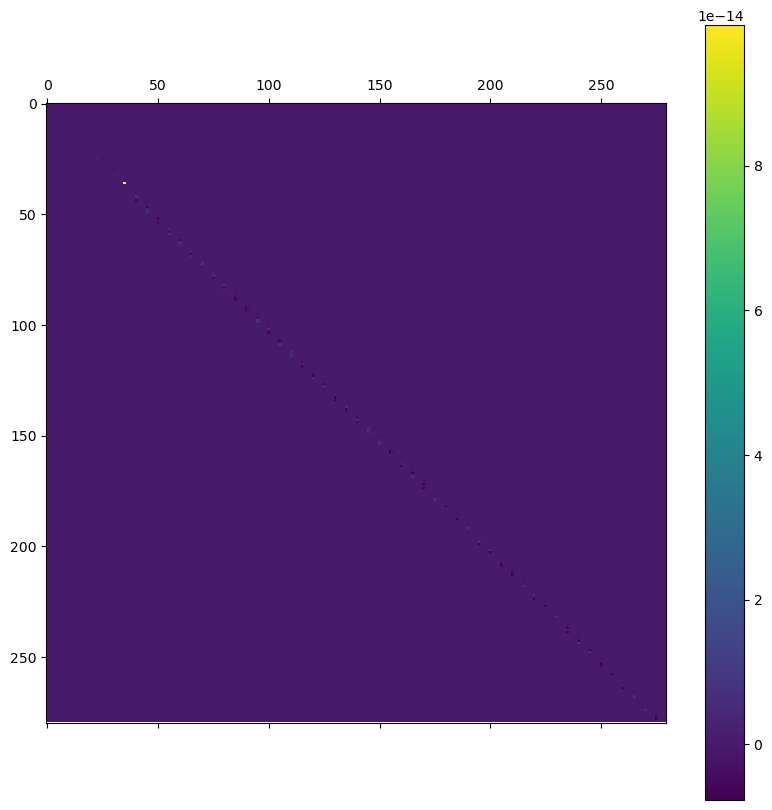

In [88]:
plt.matshow((dataset.fock_kspace[ifr][0] - rhk[ifr][0]).real)
plt.colorbar()

In [130]:
phase, indices, kpts_idx = precompute_phase(target_blocks, dataset, cutoff)
pred_kspace = TMap_bloch_sums(target_blocks, phase, indices, kpts_idx, return_tensormap = True)

In [131]:
rhk_bs = kblocks_to_matrix(pred_kspace, dataset, all_pairs = all_pairs, sort_orbs = sort_orbs )

In [132]:
for ifr in range(len(dataset)): 
    for ik in range(len(dataset.fock_kspace[ifr])):
        print(torch.norm(dataset.fock_kspace[ifr][ik] - rhk_bs[ifr][ik]))

tensor(1.2477e-13)
tensor(1.2477e-13)
tensor(1.2477e-13)
tensor(1.2477e-13)
tensor(1.2477e-13)
tensor(1.2477e-13)
tensor(1.2477e-13)
tensor(1.2477e-13)
tensor(1.2477e-13)
tensor(1.2477e-13)
tensor(1.2477e-13)
tensor(1.2477e-13)
tensor(1.2477e-13)
tensor(1.2477e-13)
tensor(1.2477e-13)
tensor(1.2477e-13)
tensor(1.2477e-13)
tensor(1.2477e-13)
tensor(1.2477e-13)
tensor(1.2477e-13)
tensor(1.2477e-13)
tensor(1.2477e-13)
tensor(1.2477e-13)
tensor(1.2477e-13)
tensor(1.2477e-13)
tensor(1.2477e-13)
tensor(1.2477e-13)


In [234]:
max_radial  = 8
max_angular = 5
atomic_gaussian_width = 0.3
# cutoff= 6
spline_basis = False


hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": splined_basis if spline_basis else {"Gto": {}},
               # "radial_basis": splined_basis,
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}
LCUT=3
hfeat = compute_features(dataset, ALL_PAIRS)

cpu pair features
cpu single center features
cpu single center features


KeyboardInterrupt: 

In [ ]:
seed = 10
torch.manual_seed(seed)
np.random.seed(seed)
      
model = LinearModelPeriodic(twocfeat = hfeat, 
                            target_blocks = target_coupled_blocks,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            bias = True,
                            nhidden = 128, 
                            nlayers = 2,
                            activation = 'SiLU',
                            apply_norm = True
                           )

model = model.double()

In [ ]:
from mlelec.utils.symmetry import ClebschGordanReal
from pathlib import Path
from mlelec.utils.twocenter_utils import _to_uncoupled_basis
from mlelec.utils.twocenter_utils import _to_coupled_basis
from mlelec.utils.pbc_utils import matrix_to_blocks, kmatrix_to_blocks, TMap_bloch_sums, precompute_phase

from mlelec.features.acdc import pair_features, single_center_features, twocenter_features_periodic_NH, twocenter_hermitian_features
import rascaline

from mlelec.metrics import L2_loss, L2_kspace_loss
from mlelec.models.linear import LinearModelPeriodic
from mlelec.utils.twocenter_utils import _to_uncoupled_basis, map_targetkeys_to_featkeys
from mlelec.utils.pbc_utils import precompute_phase, TMap_bloch_sums

from mlelec.utils.pbc_utils import blocks_to_matrix

In [20]:
pred = model()#.predict(hfeat, target_coupled_blocks)

In [42]:
for k, b in target_coupled_blocks.items():
    block = pred.block(k)
    print(b.values.shape,block.values.shape)

torch.Size([8500, 1, 1]) torch.Size([8500, 1, 1])
torch.Size([8500, 1, 1]) torch.Size([8500, 1, 1])
torch.Size([8500, 3, 1]) torch.Size([8500, 3, 1])
torch.Size([8500, 1, 1]) torch.Size([8500, 1, 1])
torch.Size([8500, 3, 1]) torch.Size([8500, 3, 1])
torch.Size([8500, 1, 1]) torch.Size([8500, 1, 1])
torch.Size([8500, 3, 1]) torch.Size([8500, 3, 1])
torch.Size([8500, 5, 1]) torch.Size([8500, 5, 1])
torch.Size([72, 1, 1]) torch.Size([72, 1, 1])
torch.Size([72, 1, 1]) torch.Size([72, 1, 1])
torch.Size([72, 3, 1]) torch.Size([72, 3, 1])
torch.Size([72, 1, 1]) torch.Size([72, 1, 1])
torch.Size([72, 3, 1]) torch.Size([72, 3, 1])
torch.Size([72, 1, 1]) torch.Size([72, 1, 1])
torch.Size([72, 3, 1]) torch.Size([72, 3, 1])
torch.Size([72, 5, 1]) torch.Size([72, 5, 1])
torch.Size([8500, 1, 1]) torch.Size([8500, 1, 1])
torch.Size([8500, 1, 1]) torch.Size([8500, 1, 1])
torch.Size([8500, 3, 1]) torch.Size([8500, 3, 1])
torch.Size([8500, 1, 1]) torch.Size([8500, 1, 1])
torch.Size([8500, 3, 1]) torch.S

In [43]:
# unc_pred = _to_uncoupled_basis(pred)
phase_c, indices, kpts_idx = precompute_phase(target_coupled_blocks, dataset, cutoff)
pred_kspace_c = TMap_bloch_sums(pred, phase_c, indices, kpts_idx, return_tensormap = True)

In [49]:
unc_pred = _to_uncoupled_basis(pred)
phase, indices, kpts_idx = precompute_phase(target_blocks, dataset, cutoff)
pred_kspace = TMap_bloch_sums(unc_pred, phase, indices, kpts_idx, return_tensormap = True)

In [46]:
for (k,b), (k1,b1) in zip(pred_kspace.items(), k_target_blocks.items()):
    print(b.values.shape, b1.values.shape)
    

torch.Size([49368, 1, 1, 1]) torch.Size([47448, 1, 1, 1])
torch.Size([49368, 1, 1, 1]) torch.Size([47448, 1, 1, 1])
torch.Size([49368, 1, 3, 1]) torch.Size([47448, 1, 3, 1])
torch.Size([49368, 1, 1, 1]) torch.Size([47448, 1, 1, 1])
torch.Size([49368, 1, 3, 1]) torch.Size([47448, 1, 3, 1])
torch.Size([49368, 3, 3, 1]) torch.Size([47448, 3, 3, 1])
torch.Size([50880, 1, 1, 1]) torch.Size([50880, 1, 1, 1])
torch.Size([50880, 1, 1, 1]) torch.Size([50880, 1, 1, 1])
torch.Size([50880, 1, 3, 1]) torch.Size([50880, 1, 3, 1])
torch.Size([50880, 1, 1, 1]) torch.Size([50880, 1, 1, 1])
torch.Size([50880, 1, 3, 1]) torch.Size([50880, 1, 3, 1])
torch.Size([50880, 3, 3, 1]) torch.Size([50880, 3, 3, 1])


In [50]:
for k, b in k_target_blocks.items():
    block = pred_kspace.block(k)
    print(b.values.shape,block.values.shape)

torch.Size([47448, 1, 1, 1]) torch.Size([49368, 1, 1, 1])
torch.Size([47448, 1, 1, 1]) torch.Size([49368, 1, 1, 1])
torch.Size([47448, 1, 3, 1]) torch.Size([49368, 1, 3, 1])
torch.Size([47448, 1, 1, 1]) torch.Size([49368, 1, 1, 1])
torch.Size([47448, 1, 3, 1]) torch.Size([49368, 1, 3, 1])
torch.Size([47448, 3, 3, 1]) torch.Size([49368, 3, 3, 1])
torch.Size([50880, 1, 1, 1]) torch.Size([50880, 1, 1, 1])
torch.Size([50880, 1, 1, 1]) torch.Size([50880, 1, 1, 1])
torch.Size([50880, 1, 3, 1]) torch.Size([50880, 1, 3, 1])
torch.Size([50880, 1, 1, 1]) torch.Size([50880, 1, 1, 1])
torch.Size([50880, 1, 3, 1]) torch.Size([50880, 1, 3, 1])
torch.Size([50880, 3, 3, 1]) torch.Size([50880, 3, 3, 1])


In [52]:
_, m1,m2 = pred_kspace[0].samples.intersection_and_mapping(k_target_blocks[0].samples)

In [59]:
k_target_blocks.keys

Labels(
    block_type  species_i  n_i  l_i  species_j  n_j  l_j
        -1          6       1    0       6       1    0
        -1          6       1    0       6       2    0
        -1          6       1    0       6       2    1
        -1          6       2    0       6       2    0
        -1          6       2    0       6       2    1
        -1          6       2    1       6       2    1
        1           6       1    0       6       1    0
        1           6       1    0       6       2    0
        1           6       1    0       6       2    1
        1           6       2    0       6       2    0
        1           6       2    0       6       2    1
        1           6       2    1       6       2    1
)

In [56]:
pred_kspace[0].samples.values[m1==-1]

LabelsValues([[  1,   0,   0,   0],
              [  1,   0,   0,   1],
              [  1,   0,   0,   2],
              ...,
              [  1,  15,  15, 117],
              [  1,  15,  15, 118],
              [  1,  15,  15, 119]], dtype=int32)

In [153]:
checkpoint = torch.load('/home/pegolo/Software/mlelec/examples/data/periodic/deepH_graphene/models/model_1500.ckpt')

In [212]:
seed = 10
torch.manual_seed(seed)
np.random.seed(seed)
      
model_rnd = LinearModelPeriodic(twocfeat = hfeat, 
                            target_blocks = target_coupled_blocks,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            bias = True,
                            nhidden = 128, 
                            nlayers = 2,
                            activation = 'SiLU',
                            apply_norm = True
                           )

model_rnd = model_rnd.double()
for k in model_rnd.model:
    with torch.no_grad():
        for name, param in model_rnd.model[k].named_parameters():
            param.copy_(torch.ones_like(param)) 

In [154]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [215]:
# pred_from_graphene = model.predict(hfeat, target_coupled_blocks)
pred_from_graphene = model_rnd.predict(hfeat, target_coupled_blocks)

In [217]:
from mlelec.metrics import L2_loss
L2_loss(pred_from_graphene, target_coupled_blocks)
# L2_loss(pred_rnd, target_coupled_blocks)

tensor(5.5343e+13, grad_fn=<AddBackward0>)

(<Figure size 3000x1000 with 2 Axes>,
 <Axes: ylabel='|H| (a.u.)'>,
 <Axes: ylabel='$|H-\\tilde{H}|^2$  (a.u.)'>)

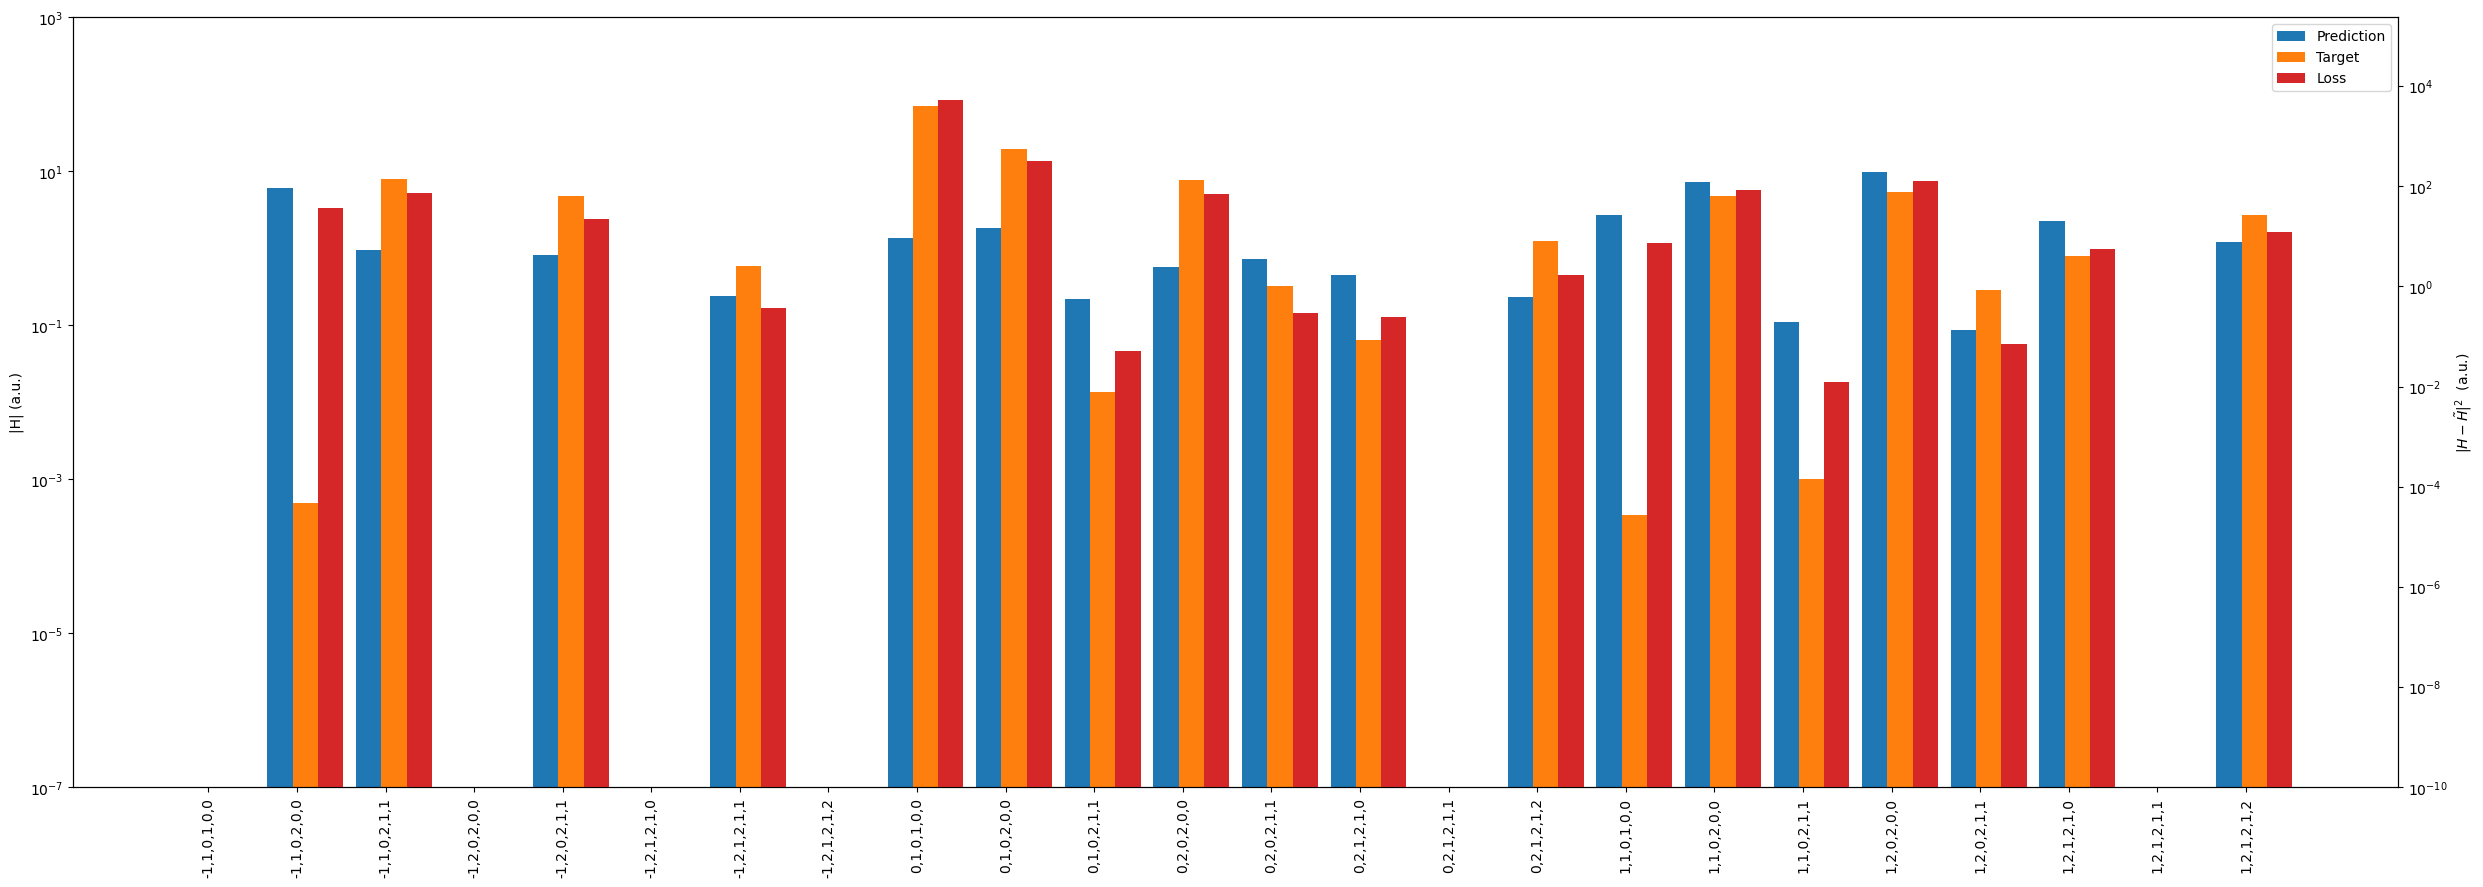

In [218]:
# plot_block_errors(target_coupled_blocks, pred_from_graphene, plot_loss=True)
plot_block_errors(target_coupled_blocks, pred_rnd, plot_loss=True)

In [219]:
recon_HT = blocks_to_matrix(pred_from_graphene, dataset)

In [220]:
recon_Hk = dataset.bloch_sum(recon_HT)

In [168]:
cutoff_overlaps = blocks_to_matrix(matrix_to_blocks(dataset, cutoff = cutoff, target='overlap'), dataset)
cutoff_target = blocks_to_matrix(target_coupled_blocks, dataset)

In [169]:
recon_Sk = dataset.bloch_sum(cutoff_overlaps)
recon_target = dataset.bloch_sum(cutoff_target)

In [221]:
from scipy.linalg import eigvalsh
eigvals_target = []
eigvals_pred = []
for A in range(len(dataset)):
    for ik in range(len(dataset.fock_kspace[A])):
        # eigvals_target.append(eigvalsh(dataset.fock_kspace[A][ik].numpy(), dataset.overlap_kspace[A][ik].numpy()))
        eigvals_target.append(eigvalsh(recon_target[A][ik].numpy(), recon_Sk[A][ik].numpy()))
        eigvals_pred.append(eigvalsh(recon_Hk[A][ik].detach().numpy(), recon_Sk[A][ik].detach().numpy()))

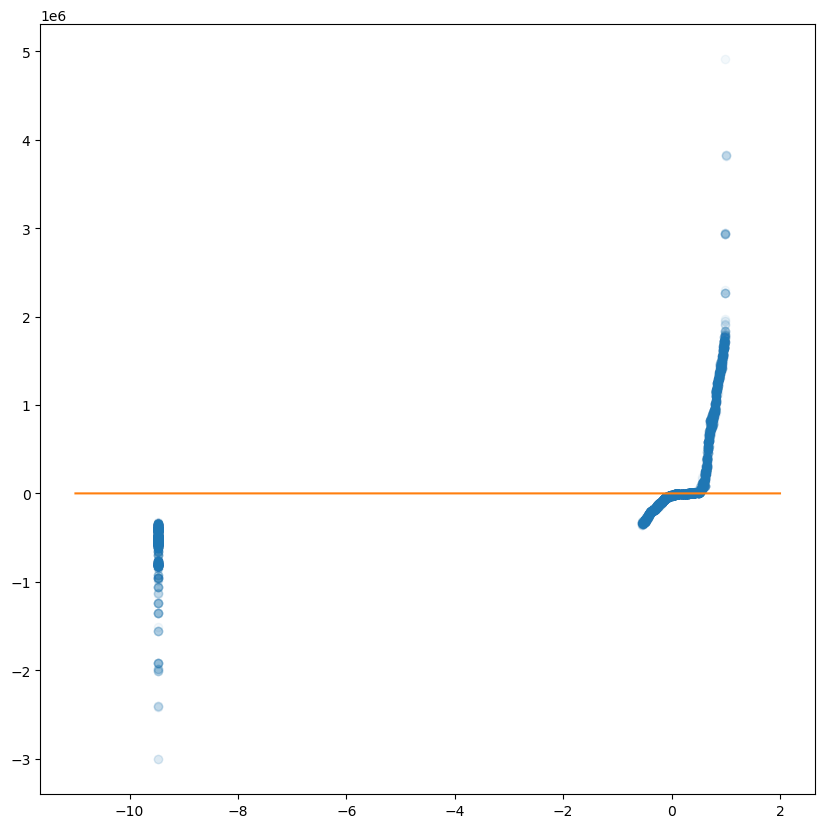

In [222]:
plt.plot(np.concatenate(eigvals_target), np.concatenate(eigvals_pred), 'o', alpha = 0.05)
plt.plot([-11,2], [-11,2])
# plt.xlim(-9.6,-9.4)
# plt.ylim(-10.7,-10)
# plt.xlim(-1,1)
# plt.ylim(-1,1)

(0.0, 360.0)

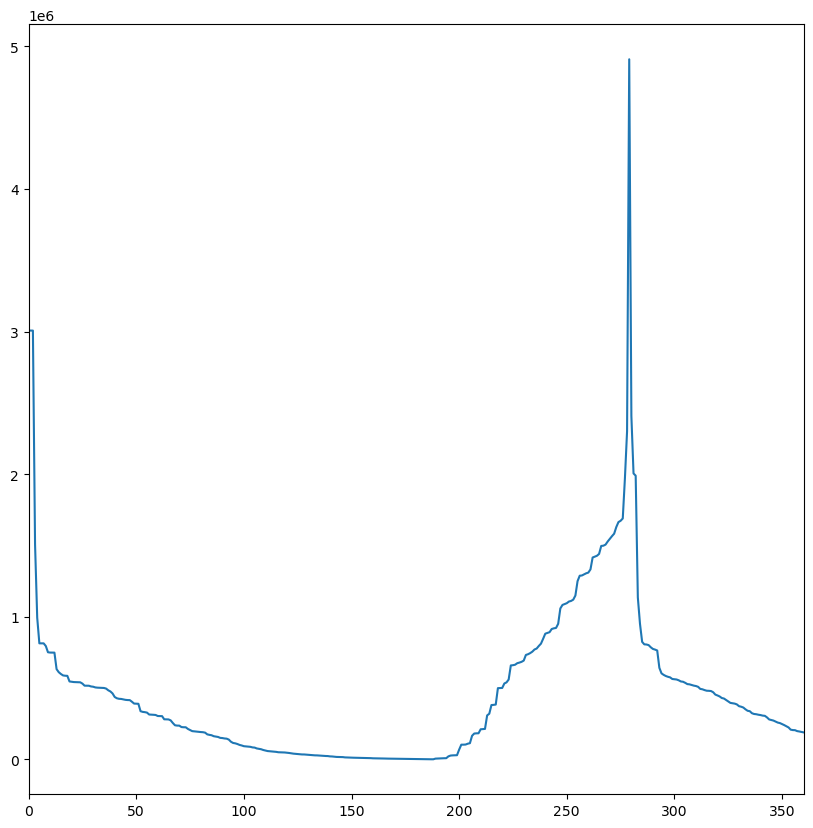

In [224]:
plt.plot(np.abs(np.concatenate(eigvals_target) - np.concatenate(eigvals_pred)))
plt.xlim(0,360)

<Popen: returncode: None args: ['/home/pegolo/micromamba/envs/sci/bin/python...>

# BENZENE - test

In [9]:
import ase
frame = ase.Atoms("C6H6")
rc = 1.384
rh = 2.465
for i in range(6):
    frame.positions[i] = [np.cos(i*np.pi/3)*rc,np.sin(i*np.pi/3)*rc,0]
    frame.positions[i+6] = [np.cos(i*np.pi/3)*rh,np.sin(i*np.pi/3)*rh,0]

In [10]:
np.random.seed(321)
fock = np.random.uniform(size=(30,30))
fock = fock+fock.T
ref_eva = np.linalg.eigvalsh(fock)

In [11]:
dataset =PySCFPeriodicDataset(frames = [frame], 
                               kmesh = [1,1,1], 
                               fix_p_orbital_order=True,
                               dimension = 2,
                               # fock_kspace = kfock, 
                               # overlap_kspace = kover, 
                              fock_realspace=[fock],#[{tuple([0,0,0]):fock}],
                               device = device, 
                               orbs = orbitals['benzene'], 
                               orbs_name = None
                               )

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/data/dataset.py:887: UserWarning: Overlap matrices not provided
  warnings.warn("Overlap matrices not provided")


In [12]:

target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = 6, device = device, all_pairs = False)

In [13]:
# plt.matshow((dataset.fock_realspace- fock)[0])

In [14]:
# %%timeit
hfeat = compute_features(dataset)

cpu pair features
cpu single center features
cpu single center features
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species


In [15]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat, 
                                  target_blocks = target_coupled_blocks,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-10, -1, 100),
                                                                         # alphas = np.logspace(-30, -6, 100),
                                                                         # alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(658.5638)


In [16]:
fock_pred = blocks_to_matrix(pred_ridge_bias, dataset)
fock_pred = next(iter(fock_pred[0].values()))

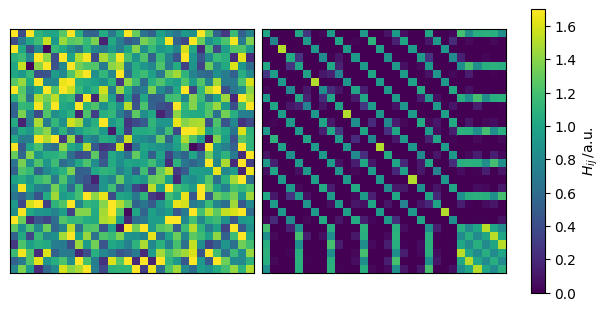

In [17]:
fig, ax = plt.subplots(1,2,figsize=(6,3), constrained_layout=True)
ax[0].matshow(fock, vmin=0, vmax=1.7, interpolation='None')
ms = ax[1].matshow(fock_pred, vmin=0, vmax=1.7, interpolation='None')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
fig.colorbar(ms, ax=ax.ravel().tolist(), label=r"$H_{ij}\,/$a.u.")

3.5865086555972887
0.016273980152756308
0.5076514124395723


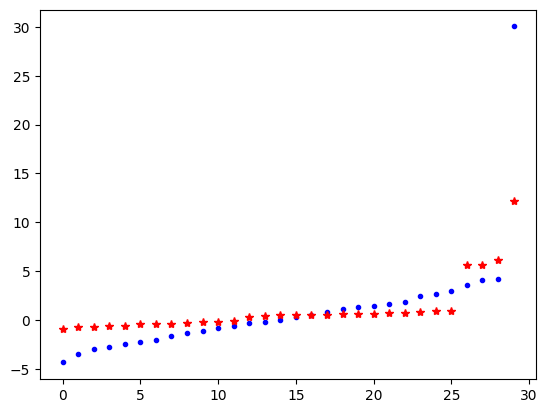

In [18]:
eva_ref = np.linalg.eigvalsh(fock)
eva_pred = np.linalg.eigvalsh(fock_pred)
plt.plot(eva_ref, 'b.')
plt.plot(eva_pred, 'r*') 
print(np.sqrt(np.mean((np.linalg.eigvalsh(fock)-np.linalg.eigvalsh(fock_pred))**2)))
print(np.linalg.eigvalsh(fock)[14])
print(np.linalg.eigvalsh(fock_pred)[14])

## displace

In [19]:
ld = np.linspace(-0.1,0.1,31)
frames_displace = []
fockdummy = []
for i,d in enumerate(ld):
    fd = frame.copy()    
    cent = fd.positions.mean(axis=0)
    fd.positions -= cent
    # q3hat
    # fd.positions[[-5,-3,-1]] *= 1+d
    # fd.positions[[-6,-4,-2]] *= 1-d
    # q2hat
    fd.positions[[-5,-2]] *= 1+d
    fd.positions[[-6,-3]] *= 1-d
    fd.positions += cent
    frames_displace.append(fd)
    fockdummy.append(np.zeros_like(fock))
    
dataset_displaced = PySCFPeriodicDataset(frames = frames_displace, 
                               kmesh = [1,1,1], 
                               fix_p_orbital_order=True,
                               dimension = 2,
                               # fock_kspace = kfock, 
                               # overlap_kspace = kover, 
                              fock_realspace=fockdummy,
                               device = device, 
                               orbs = orbitals['benzene'], 
                               orbs_name = None
                               )


/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/data/dataset.py:887: UserWarning: Overlap matrices not provided
  warnings.warn("Overlap matrices not provided")


In [20]:
hfeat_d = compute_features(dataset_displaced)

cpu pair features
cpu single center features
cpu single center features
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species


In [21]:
pred_disp = model_ridge.predict_ridge_analytical(ridges = ridges_bias, hfeat=hfeat_d)

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/models/linear.py:707: UserWarning: Using train target_blocks, otherwise provide test target_blocks
  warnings.warn('Using train target_blocks, otherwise provide test target_blocks')


In [22]:
fockd = blocks_to_matrix(pred_disp, dataset_displaced)
fock_disp=[] 
for i in range(len(frames_displace)):
    fock_disp.append(fockd[i][0,0,0].numpy())
    # print(fock_disp[-1].shape)

In [23]:
for f in fock_disp:
    assert np.linalg.norm(f - f.T)<1e-14

In [24]:
fockd = blocks_to_matrix(pred_disp, dataset_displaced)
evd = [np.linalg.eigh(f) for f in fock_disp]
dd = np.asarray([np.sqrt(((frames_displace[i].positions-frames_displace[len(frames_displace)//2].positions)**2).mean())*np.sign(ld[i]) for i in range(len(frames_displace)) ])

In [25]:
evd = [np.linalg.eigh(f) for f in fock_disp]
dd = np.asarray([np.sqrt(((frames_displace[i].positions-frames_displace[len(frames_displace)//2].positions)**2).mean())*np.sign(ld[i]) for i in range(len(frames_displace)) ])

Text(0, 0.5, '$\\epsilon_k$ / a.u.')

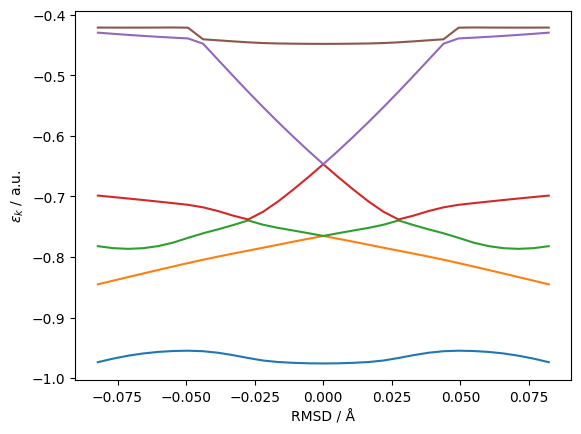

In [26]:
for k in range(0,6):
    plt.plot(dd, [evd[i][0][k] for i in range(len(ld))])   
plt.xlabel("RMSD / Å")
plt.ylabel(r"$\epsilon_k$ / a.u.")
# plt.savefig("../figures/benzene-deformations.svg")

In [93]:
rad = {'C':0.25, 'H':0.15}
col = {'C': 'gray', 'H': 'white'}
def mo_plot(ax, mol, orbs, eve):
    cent = mol.positions.mean(axis=0)
    
    mo_xy = mo_compute(gv_xy, mol, orbs, eve, project=(1,1,0), sigma=0.25).reshape(ngrid,ngrid)
    ax.contourf(xgrid, ygrid, mo_xy, levels=[-0.01,0.01], 
                extend='both', colors=['blue','white','red'])
    
    for i in range(len(mol)):
        ax.add_patch(plt.Circle((mol.positions[i]-cent)[:2], rad[mol.symbols[i]], fill=False, ec='black' ))

[]

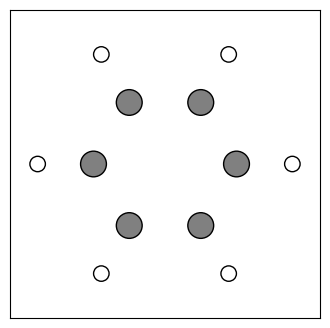

In [94]:
fig, ax = plt.subplots(figsize=(4,4))
mol = frames_displace[len(ld)//2]
cent=mol.positions.mean(axis=0)
for i in range(len(mol)):
    ax.add_patch(plt.Circle((mol.positions[i]-cent)[:2], rad[mol.symbols[i]], fc=col[mol.symbols[i]], ec='black' ))
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.set_xticks([])
ax.set_yticks([])

# BN

In [155]:
workdir = '.'
root = f'{workdir}/examples/data/periodic'
ORBS = 'sto-3g'
START = 0
STOP = 1
frames = read(f'{root}/BN/BN_unit_cell.xyz', slice(START, STOP))
for f in frames:
    f.pbc= True

kmesh = [[8,8,1]]
kfock = [np.load(f"{root}/BN/fock.npy", allow_pickle = True) for i in range(START, STOP)]
kover = [np.load(f"{root}/BN/over.npy", allow_pickle = True) for i in range(START, STOP)]

dataset = PySCFPeriodicDataset(frames = frames, 
                               kmesh = kmesh, 
                               fix_p_orbital_order=True,
                               dimension = 2,
                               # fock_kspace = kover, 
                               fock_kspace = kfock, 
                               overlap_kspace = kover, 
                               device = device, 
                               orbs = orbitals[ORBS], 
                               orbs_name = 'sto-3g')

In [156]:
# for ALL_PAIRS in [ False,True]:
#     for SORT_ORBS in [False,True,]:
#         cutoff = 3
#         kblocks = kmatrix_to_blocks(dataset, cutoff = cutoff, all_pairs = ALL_PAIRS, sort_orbs=SORT_ORBS)
#         rhk = kblocks_to_matrix(kblocks, dataset, all_pairs=ALL_PAIRS, sort_orbs=SORT_ORBS)        
#         for ifr in range(len(kfock)):
#             for ik in range(len(kfock[ifr])):
#                 # print(np.linalg.norm(kfock[ifr][ik] -kfock[ifr][ik].conj().T))
#                 # print(np.linalg.norm(kfock[ifr][ik]-rhk[ifr][ik].numpy()))
#                 assert (np.linalg.norm(kfock[ifr][ik]-rhk[ifr][ik].numpy()))<1e-13, (ALL_PAIRS, SORT_ORBS)
#         print(ALL_PAIRS, SORT_ORBS, 'passed')

In [157]:
ALL_PAIRS=False
SORT_ORBS=False
cutoff = 20
kblocks = kmatrix_to_blocks(dataset, cutoff = cutoff, all_pairs = ALL_PAIRS, sort_orbs=SORT_ORBS)
rhk = kblocks_to_matrix(kblocks, dataset, all_pairs=ALL_PAIRS, sort_orbs=SORT_ORBS)
# torch.norm(rhk[0] - dataset.fock_kspace[0])
# kblocks_o = kmatrix_to_blocks(dataset, cutoff = cutoff, all_pairs = ALL_PAIRS, target='overlap')
# rSk = kblocks_to_matrix(kblocks_o, dataset, all_pairs=ALL_PAIRS)
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = ALL_PAIRS, sort_orbs=SORT_ORBS)
rht = blocks_to_matrix(target_coupled_blocks, dataset, all_pairs=ALL_PAIRS, sort_orbs=SORT_ORBS)

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/utils/pbc_utils.py:37: UserWarning: Structure 0 is not large enough for the selected cutoff. Real space target computed with cutoff of 7.25 Angstrom
  phys_cutoff = np.min(lengths/2)


In [144]:
torch.norm(rhk[0]-dataset.fock_kspace[0])

tensor(2.9164e-14)

In [59]:
from mlelec.utils.pbc_utils import inverse_bloch_sum

In [60]:
cuts=[]
errs=[]
nt=[]
targ = dataset.fock_kspace[0]
for cut in np.linspace(3, 14):
    rH = inverse_bloch_sum(dataset, targ, 0, cut)
    kH = dataset.bloch_sum([rH])
    print('{:.2f} {:d} {:.2f} {:d}'.format(cut, len(rH), torch.norm(kH[0]- targ), np.max(list(rH.keys()))))
    cuts.append(cut)
    errs.append(torch.norm(kH[0]- targ))
    nt.append(len(rH))
cuts = np.array(cuts)
errs = np.array(errs)
nt= np.array(nt)

ValueError: Unknown format code 'd' for object of type 'float'

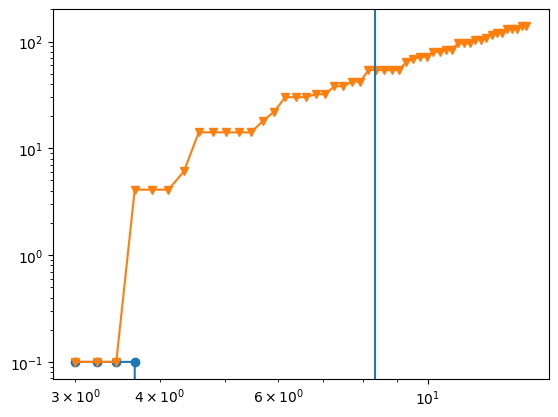

In [17]:
plt.loglog(cuts, errs-errs[0]+1e-1, '-o')
plt.loglog(cuts, nt-nt[0]+1e-1, '-v')
plt.axvline(8.35)

In [28]:
# from scipy.linalg import eigvalsh
# eigactual = []
# eigcut=[]
# for ik in range(64):
#     eigactual.append(eigvalsh(dataset.fock_kspace[0][ik].numpy(), dataset.overlap_kspace[0][ik].numpy()))
#     eigcut.append(eigvalsh(rhk[0][ik].numpy(), rSk[0][ik].numpy()))
# eigactual = np.concatenate(eigactual)
# eigcut = np.concatenate(eigcut)    
# plt.plot(eigactual, eigcut, 'o')
# plt.plot([np.min(eigactual), np.max(eigactual)],[np.min(eigactual), np.max(eigactual)])
# plt.ylim(-2,)
# plt.xlim(-2,)

In [29]:
# for ifr in range(len(kfock)):
#     for ik in range(len(kfock[ifr])):
#         # assert torch.norm(rhk[ifr][ik] - rhk[ifr][ik].conj().T)<1e-12
#         # assert np.linalg.norm(kfock[ifr][ik] -kfock[ifr][ik].conj().T)<1e-12
#         assert np.linalg.norm(kfock[ifr][ik] -rhk[ifr][ik].numpy())<1e-12


In [158]:
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = ALL_PAIRS, sort_orbs=SORT_ORBS)

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/utils/pbc_utils.py:37: UserWarning: Structure 0 is not large enough for the selected cutoff. Real space target computed with cutoff of 7.25 Angstrom
  phys_cutoff = np.min(lengths/2)


In [159]:
rht = blocks_to_matrix(target_coupled_blocks, dataset, all_pairs  =ALL_PAIRS, sort_orbs=SORT_ORBS)

In [160]:
# for ifr in range(len(rht)):
#     for T in rht[ifr]:
#         mT = tuple(-t for t in T)
#         assert torch.norm(rht[ifr][T] - rht[ifr][mT].T)<1e-12, torch.norm(rht[ifr][T] - rht[ifr][mT].T)

In [161]:
max_radial  = 6
max_angular = 4
atomic_gaussian_width = 0.6
spline_basis = False

hypers_pair = {'cutoff': cutoff,
               
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": splined_basis if spline_basis else {"Gto": {}},
               # "radial_basis": splined_basis,
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}
LCUT=4
hfeat = compute_features(dataset, ALL_PAIRS)

cpu pair features
cpu single center features
cpu single center features


In [171]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat, 
                                  target_blocks = target_coupled_blocks,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-10, 0, 100),
                                                                         # alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

/home/nigam/miniconda3/envs/temp/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:2057: RuntimeWarning: invalid value encountered in divide
  squared_errors = (c / G_inverse_diag) ** 2
/home/nigam/miniconda3/envs/temp/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:2057: RuntimeWarning: invalid value encountered in divide
  squared_errors = (c / G_inverse_diag) ** 2
/home/nigam/miniconda3/envs/temp/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:2057: RuntimeWarning: invalid value encountered in divide
  squared_errors = (c / G_inverse_diag) ** 2
/home/nigam/miniconda3/envs/temp/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:2057: RuntimeWarning: invalid value encountered in divide
  squared_errors = (c / G_inverse_diag) ** 2
/home/nigam/miniconda3/envs/temp/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:2057: RuntimeWarning: invalid value encountered in divide
  squared_errors = (c / G_inverse_diag) ** 2
/home/nigam/minicond

tensor(0.0002)


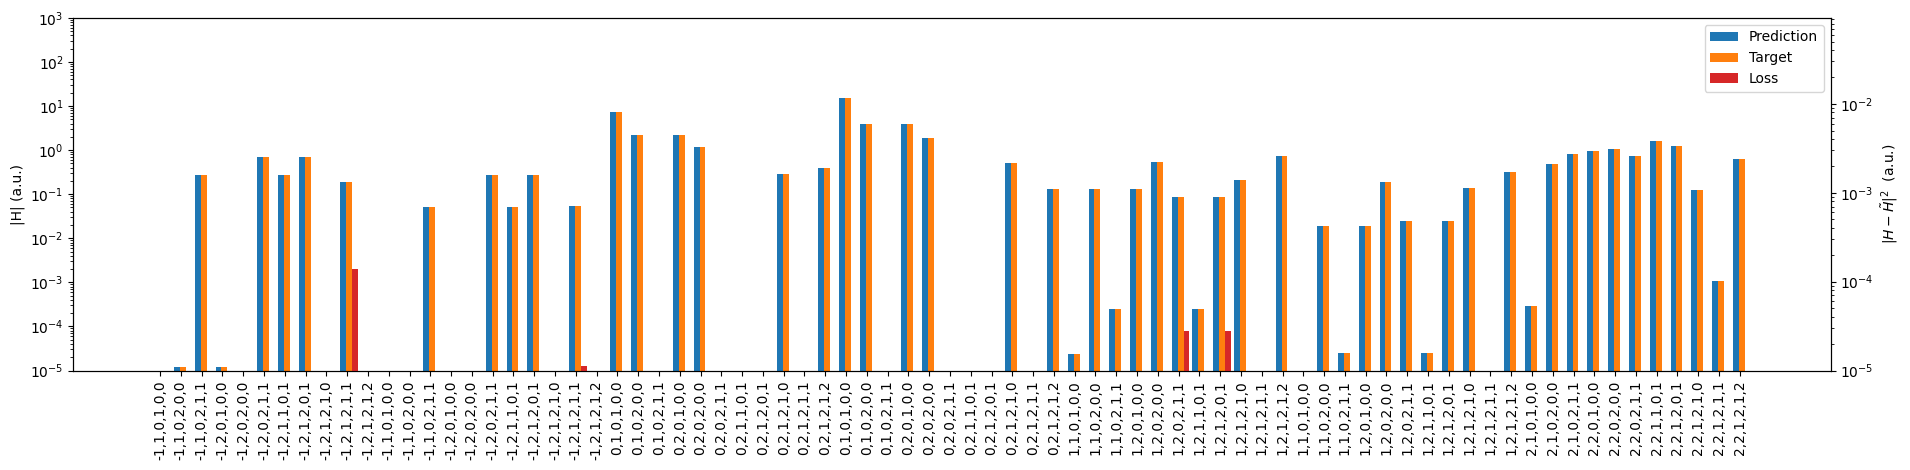

In [172]:
from mlelec.utils.plot_utils import plot_block_errors
fig,ax,ax_loss=plot_block_errors(target_coupled_blocks, pred_ridge_bias, plot_loss = True)
ax_loss.set_ylim(1e-5,)
ax.set_ylim(1e-5,)
fig.tight_layout()

In [173]:
rht_ridge = blocks_to_matrix(pred_ridge_bias, dataset,all_pairs  =ALL_PAIRS, sort_orbs=SORT_ORBS)
# rht_ridge1 = blocks_to_matrix(pred_ridge_bias, dataset, all_pairs= True)

In [174]:
for ifr in range(len(dataset)):
    for T in rht_ridge[ifr]:
        print(torch.norm(rht_ridge[ifr][T] - rht[ifr][T]) )

tensor(0.0011)
tensor(0.0011)
tensor(0.0004)
tensor(0.0004)
tensor(0.0004)
tensor(0.0004)
tensor(0.0011)
tensor(0.0011)
tensor(0.0010)
tensor(0.0010)
tensor(0.0003)
tensor(0.0003)
tensor(0.0004)
tensor(0.0004)
tensor(8.9793e-05)
tensor(8.9793e-05)
tensor(0.0004)
tensor(0.0004)
tensor(0.0002)
tensor(0.0002)
tensor(0.0010)
tensor(0.0010)
tensor(0.0010)
tensor(0.0010)
tensor(0.0009)
tensor(0.0009)
tensor(0.0013)
tensor(0.0013)
tensor(0.0007)
tensor(0.0007)
tensor(0.0002)
tensor(0.0002)
tensor(0.0002)
tensor(0.0002)
tensor(0.0007)
tensor(0.0007)
tensor(0.0013)
tensor(0.0013)
tensor(0.0009)
tensor(0.0009)
tensor(0.0010)
tensor(0.0010)
tensor(0.0011)
tensor(0.0011)
tensor(0.0002)
tensor(0.0002)
tensor(0.0013)
tensor(0.0013)
tensor(0.0005)
tensor(0.0005)
tensor(0.0008)
tensor(0.0008)
tensor(0.0009)
tensor(0.0009)
tensor(0.0002)
tensor(0.0002)
tensor(0.0009)
tensor(0.0009)
tensor(0.0008)
tensor(0.0008)
tensor(0.0005)
tensor(0.0005)
tensor(0.0013)
tensor(0.0013)
tensor(0.0002)
tensor(0.0002)
te

In [184]:
from mlelec.utils.twocenter_utils import _to_uncoupled_basis
# unc_pred = _to_uncoupled_basis(pred_ridge_bias)
unc_pred = _to_uncoupled_basis(target_coupled_blocks)
phase, indices = precompute_phase(target_blocks, dataset, cutoff = cutoff)
pred_kspace = TMap_bloch_sums(unc_pred, phase, indices, return_tensormap=True)

In [185]:
rhk_bloch = kblocks_to_matrix(pred_kspace, dataset,all_pairs  =ALL_PAIRS, sort_orbs=SORT_ORBS)
for ifr in range(len(dataset)):
    for ik in range(len(rhk_ridge_fourier[ifr])):#[ifr
        print(torch.norm(rhk_bloch[ifr][ik] - dataset.fock_kspace[ifr][ik]))

tensor(0.0038)
tensor(0.0026)
tensor(0.0012)
tensor(0.0011)
tensor(0.0012)
tensor(0.0011)
tensor(0.0012)
tensor(0.0026)
tensor(0.0026)
tensor(0.0035)
tensor(0.0025)
tensor(0.0023)
tensor(0.0007)
tensor(0.0019)
tensor(0.0007)
tensor(0.0009)
tensor(0.0012)
tensor(0.0025)
tensor(0.0035)
tensor(0.0031)
tensor(0.0032)
tensor(0.0013)
tensor(0.0019)
tensor(0.0007)
tensor(0.0011)
tensor(0.0023)
tensor(0.0031)
tensor(0.0024)
tensor(0.0032)
tensor(0.0040)
tensor(0.0013)
tensor(0.0019)
tensor(0.0012)
tensor(0.0007)
tensor(0.0032)
tensor(0.0032)
tensor(0.0029)
tensor(0.0032)
tensor(0.0032)
tensor(0.0007)
tensor(0.0011)
tensor(0.0019)
tensor(0.0013)
tensor(0.0040)
tensor(0.0032)
tensor(0.0024)
tensor(0.0031)
tensor(0.0023)
tensor(0.0012)
tensor(0.0007)
tensor(0.0019)
tensor(0.0013)
tensor(0.0032)
tensor(0.0031)
tensor(0.0035)
tensor(0.0025)
tensor(0.0026)
tensor(0.0009)
tensor(0.0007)
tensor(0.0019)
tensor(0.0007)
tensor(0.0023)
tensor(0.0025)
tensor(0.0035)


In [175]:
from mlelec.utils.pbc_utils import inverse_fourier_transform
rhk_ridge_fourier = dataset.bloch_sum(rht_ridge) # prediction from ridge
rhk_fourier = dataset.bloch_sum(rht) #original data  i.,e, reconstructed matrix from target_coupled_blocks
# kpts = torch.from_numpy(dataset.kpts_rel[0])
# pred_H = torch.stack(list(rht_ridge[0].values()))
# T = torch.from_numpy(np.array(list(rht_ridge[0].keys()), dtype = np.float64))
# inverse_fourier_transform(pred_H, T_list = T, k=kpts, norm = 1/8)


In [183]:
for ifr in range(len(dataset)):
    for ik in range(len(rhk_fourier[ifr])):#[ifr]:
        print(ik,torch.norm(rhk_ridge_fourier[ifr][ik] - dataset.fock_kspace[ifr][ik]))

0 tensor(1.3505)
1 tensor(1.3527)
2 tensor(1.2791)
3 tensor(1.0710)
4 tensor(0.9264)
5 tensor(1.0710)
6 tensor(1.2791)
7 tensor(1.3527)
8 tensor(1.3527)
9 tensor(1.3527)
10 tensor(1.3119)
11 tensor(1.1407)
12 tensor(0.9087)
13 tensor(0.9087)
14 tensor(1.1407)
15 tensor(1.3119)
16 tensor(1.2791)
17 tensor(1.3119)
18 tensor(1.2791)
19 tensor(1.1407)
20 tensor(0.8894)
21 tensor(0.7121)
22 tensor(0.8894)
23 tensor(1.1407)
24 tensor(1.0710)
25 tensor(1.1407)
26 tensor(1.1407)
27 tensor(1.0710)
28 tensor(0.9087)
29 tensor(0.7121)
30 tensor(0.7121)
31 tensor(0.9087)
32 tensor(0.9264)
33 tensor(0.9087)
34 tensor(0.8894)
35 tensor(0.9087)
36 tensor(0.9264)
37 tensor(0.9087)
38 tensor(0.8894)
39 tensor(0.9087)
40 tensor(1.0710)
41 tensor(0.9087)
42 tensor(0.7121)
43 tensor(0.7121)
44 tensor(0.9087)
45 tensor(1.0710)
46 tensor(1.1407)
47 tensor(1.1407)
48 tensor(1.2791)
49 tensor(1.1407)
50 tensor(0.8894)
51 tensor(0.7121)
52 tensor(0.8894)
53 tensor(1.1407)
54 tensor(1.2791)
55 tensor(1.3119)
56

In [177]:
for ifr in range(len(dataset)):
    for ik in range(len(rhk_fourier[ifr])):#[ifr]:
        print(ik,torch.norm(rhk_fourier[ifr][ik] - dataset.fock_kspace[ifr][ik]) )

0 tensor(1.3504)
1 tensor(1.3527)
2 tensor(1.2793)
3 tensor(1.0698)
4 tensor(0.9251)
5 tensor(1.0698)
6 tensor(1.2793)
7 tensor(1.3527)
8 tensor(1.3527)
9 tensor(1.3527)
10 tensor(1.3118)
11 tensor(1.1406)
12 tensor(0.9070)
13 tensor(0.9070)
14 tensor(1.1406)
15 tensor(1.3118)
16 tensor(1.2793)
17 tensor(1.3118)
18 tensor(1.2793)
19 tensor(1.1406)
20 tensor(0.8889)
21 tensor(0.7298)
22 tensor(0.8889)
23 tensor(1.1406)
24 tensor(1.0698)
25 tensor(1.1406)
26 tensor(1.1406)
27 tensor(1.0698)
28 tensor(0.9070)
29 tensor(0.7298)
30 tensor(0.7298)
31 tensor(0.9070)
32 tensor(0.9251)
33 tensor(0.9070)
34 tensor(0.8889)
35 tensor(0.9070)
36 tensor(0.9251)
37 tensor(0.9070)
38 tensor(0.8889)
39 tensor(0.9070)
40 tensor(1.0698)
41 tensor(0.9070)
42 tensor(0.7298)
43 tensor(0.7298)
44 tensor(0.9070)
45 tensor(1.0698)
46 tensor(1.1406)
47 tensor(1.1406)
48 tensor(1.2793)
49 tensor(1.1406)
50 tensor(0.8889)
51 tensor(0.7298)
52 tensor(0.8889)
53 tensor(1.1406)
54 tensor(1.2793)
55 tensor(1.3118)
56

In [168]:
A = 0
from ase.units import Bohr
T_list = np.linalg.solve(dataset.cells[A].lattice_vectors().T, dataset.cells[A].get_lattice_Ls(rcut = cutoff/Bohr, dimension = 2, discard = False).T).T
assert np.linalg.norm(T_list - np.round(T_list)) < 1e-9, np.linalg.norm(Ts - np.round(Ts))
Ts = torch.from_numpy(np.round(T_list))
T_list = np.int32(np.round(T_list))

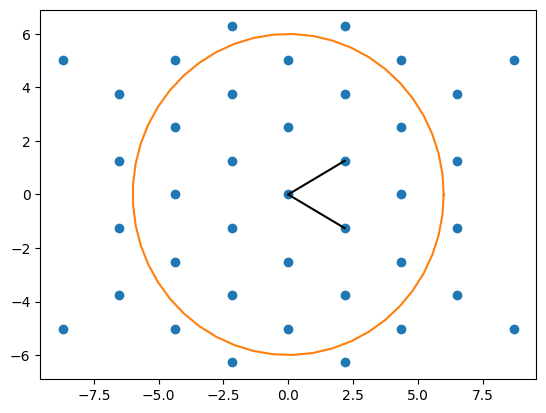

In [169]:
cell = dataset.structures[0].cell.array
x, y, _ = np.einsum('ba,Tb->Ta', cell, T_list).T
plt.plot(x, y, 'o')
plt.plot([0, cell[0,0]], [0, cell[0,1]], 'k')
plt.plot([0, cell[1,0]], [0, cell[1,1]], 'k')
th = np.linspace(0, 2*np.pi)
plt.plot(cutoff*np.cos(th), cutoff*np.sin(th))

# HOW ARE WE MAKING THIS LARGE AN ERROR on KSPACE when HT is so good???

but at least TMap bloch sum and inverse fourier are consistent

In [100]:
seed = 10
torch.manual_seed(seed)
np.random.seed(seed)
      
model = LinearModelPeriodic(twocfeat = hfeat, 
                            target_blocks = target_coupled_blocks,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            bias = False, #True
                            nhidden = 512, 
                            nlayers = 0,
                            # activation = 'SiLU',
                            # apply_norm = True
                           )

model = model.double()

In [101]:
pred = model()

In [102]:
from mlelec.utils.pbc_utils import TMap_bloch_sums
from mlelec.utils.twocenter_utils import _to_uncoupled_basis

In [103]:
phase, indices = precompute_phase(_to_uncoupled_basis(pred), dataset, cutoff=cutoff)
predk=TMap_bloch_sums(_to_uncoupled_basis(pred), phase, indices, return_tensormap=True)

In [104]:
predk_mat = kblocks_to_matrix(predk, dataset)

# MoS2

In [155]:
workdir = '.'
root = f'{workdir}/examples/data/periodic'
ORBS = 'gthszvmolopt'
START = 0
STOP = 1
frames = read(f'{root}/deepH_MoS2/deepH_MoS2.xyz', slice(START, STOP))
for f in frames:
    f.pbc= True

kmesh = [[1,1,1]]
rfock = [np.load(f"{root}/deepH_MoS2/SVB/0/realfock_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]
rover = [np.load(f"{root}/deepH_MoS2/SVB/0/realoverlap_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]

dataset = PySCFPeriodicDataset(frames = frames, 
                               kmesh = kmesh, 
                               fix_p_orbital_order=False,
                               dimension = 2,
                               fock_realspace = rfock, 
                               overlap_realspace = rover, 
                               device = device, 
                               orbs = orbitals[ORBS], 
                               orbs_name = 'gthszvmolopt'+'sr')

WARNING!
  Very diffused basis functions are found in the basis set. They may lead to severe
  linear dependence and numerical instability.  You can set  cell.exp_to_discard=0.1
  to remove the diffused Gaussians whose exponents are less than 0.1.



In [73]:
cutoff = 6
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = ALL_PAIRS, sort_orbs = SORT_ORBS)
# target_blocks1, target_coupled_blocks1 = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = True, sort_orbs = SORT_ORBS)

In [29]:
max_radial  = 6
max_angular = 4
atomic_gaussian_width = 0.8
cutoff= 8
spline_basis = False


hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": splined_basis if spline_basis else {"Gto": {}},
               # "radial_basis": splined_basis,
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}
LCUT=4
hfeat = compute_features(dataset, ALL_PAIRS)

cpu pair features


/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/features/acdc.py:147: UserWarning: The selected cutoff is less than the maximum distance as repeated for kmesh (26.0) among atoms in the system!
  warnings.warn(f"The selected cutoff is less than the maximum distance as repeated for kmesh ({np.ceil(min_cutoff)}) among atoms in the system!")


cpu single center features
cpu single center features


In [72]:
SORT_ORBS=True 

In [74]:
seed = 10
torch.manual_seed(seed)
np.random.seed(seed)
      
model = LinearModelPeriodic(twocfeat = hfeat, 
                            target_blocks = target_coupled_blocks,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            bias = False, #True
                            nhidden = 512, 
                            nlayers = 1,
                            # activation = 'SiLU',
                            # apply_norm = True
                           )

model = model.double()

In [75]:
pred = model()#.predict(hfeat, target_coupled_blocks)

In [96]:

# blocks = matrix_to_blocks(dataset, cutoff = cutoff, all_pairs = ALL_PAIRS, sort_orbs=SORT_ORBS)
rht = blocks_to_matrix(pred, dataset, all_pairs=ALL_PAIRS, sort_orbs=SORT_ORBS)        

In [97]:
for ifr in range(len(dataset)):
    for T in rht[ifr]:
        mT = tuple(-t for t in T)
        print(T,torch.norm(rht[ifr][T]- rht[ifr][mT].T ))

(-1, -1, 0) tensor(3.1245e-18)
(1, 1, 0) tensor(3.1245e-18)
(-1, 0, 0) tensor(6.9093e-18)
(1, 0, 0) tensor(6.9093e-18)
(-1, 1, 0) tensor(6.1349e-19)
(1, -1, 0) tensor(6.1349e-19)
(0, -1, 0) tensor(7.5676e-18)
(0, 1, 0) tensor(7.5676e-18)
(0, 0, 0) tensor(2.2880e-17)


(<Figure size 1000x1000 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f5eb91bb050>)

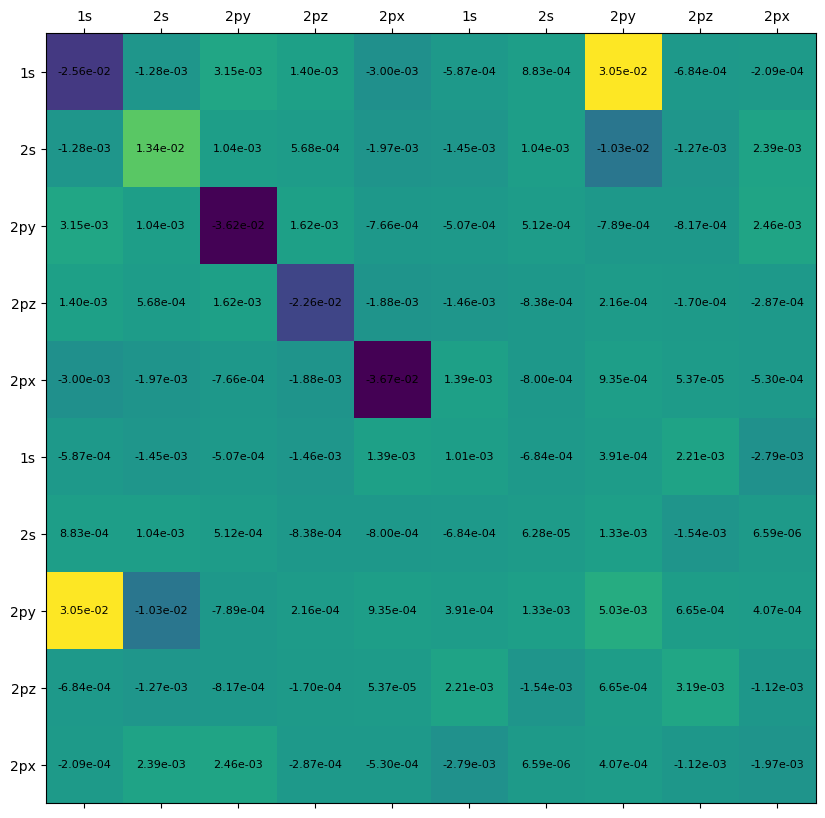

In [98]:
plot_hamiltonian(rht[ifr][0,0,0][:10,:10])

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f5eb933b190>)

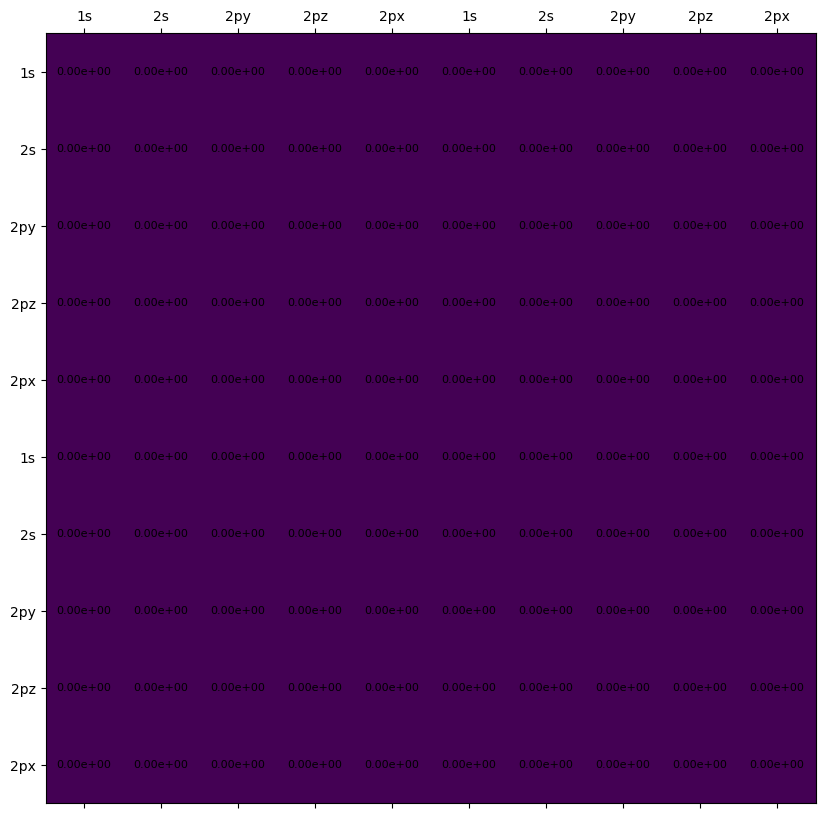

In [99]:
from mlelec.utils.plot_utils import plot_hamiltonian
plt.rcParams['figure.figsize']=(10,10)
plot_hamiltonian(rht[ifr][0,0,0][:10,:10]-rht[ifr][0,0,0].T[:10,:10])

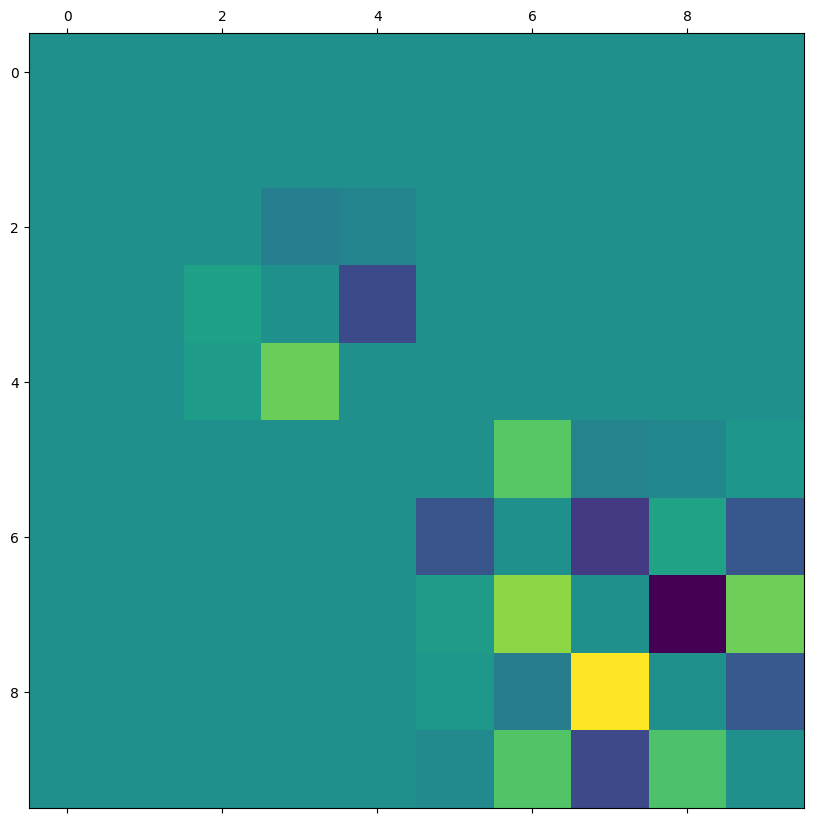

In [65]:
plt.matshow( (rht[ifr][0,0,0] - rht[ifr][0,0,0].T)[:10,:10])

In [156]:
cutoff = 50

In [169]:
del rhk, ik

In [185]:
for ALL_PAIRS in [False,True]:
    for SORT_ORBS in [False, True]:
        try:
            blocks = matrix_to_blocks(dataset, cutoff = cutoff, all_pairs = ALL_PAIRS, sort_orbs=SORT_ORBS)
            rht = blocks_to_matrix(blocks, dataset, all_pairs=ALL_PAIRS, sort_orbs=SORT_ORBS)        
            for ifr in range(len(dataset.fock_realspace)):
                for T in dataset.fock_realspace[ifr]:
                    # print(np.linalg.norm(kfock[ifr][ik] -kfock[ifr][ik].conj().T))
                    # print(np.linalg.norm(kfock[ifr][ik]-rhk[ifr][ik].numpy()))
                    assert (np.linalg.norm(dataset.fock_realspace[ifr][T]-rht[ifr][T].numpy()))<1e-13, (ALL_PAIRS, SORT_ORBS,np.linalg.norm(dataset.fock_realspace[ifr][T]-rht[ifr][T].numpy()))
            print(ALL_PAIRS, SORT_ORBS, 'passed')
        except Exception as e:
            print(e)
            print(ALL_PAIRS, SORT_ORBS, 'failed - moving on')
            break

False False passed
False True passed
True False passed
True True passed


In [162]:
frames[0]

Atoms(symbols='Mo25S50', pbc=True, cell=[[15.981115, 0.0, 0.0], [-7.99056, 13.84005, 0.0], [0.0, 0.0, 29.999999999999996]])

In [182]:
print_matrix(rht[0][0,0,0][0:10,250:254])

   0.0251615127   -0.0262702379    0.0453582944    0.0453850834
  -0.0845011332    0.0237877399   -0.0565268910   -0.0410393728
  -0.0119948464   -0.0020807667   -0.0185390061   -0.0182037031
   0.0207246165   -0.0183089521    0.0194640577    0.0316501838
   0.0207322326   -0.0182147634    0.0320669049    0.0188575721
  -0.0245048453   -0.0067570694   -0.0233246792   -0.0093723106
  -0.0230476295   -0.0059833272   -0.0111063183   -0.0190460346
   0.0056040588   -0.0090681267   -0.0144070028    0.0157649033
   0.0397466302   -0.0189500717    0.0191488924    0.0156664519
   0.0140820727   -0.0173196915    0.0133880646   -0.0069715648


In [183]:
print_matrix(dataset.fock_realspace[0][0,0,0][0:10,250:254])

   0.0503230253   -0.0525404759    0.0907165889    0.0907701669
  -0.1690022664    0.0475754797   -0.1130537820   -0.0820787456
  -0.0239896929   -0.0041615335   -0.0370780123   -0.0364074062
   0.0414492330   -0.0366179042    0.0389281154    0.0633003677
   0.0414644652   -0.0364295268    0.0641338097    0.0377151442
  -0.0490096906   -0.0135141389   -0.0466493583   -0.0187446213
  -0.0460952591   -0.0119666543   -0.0222126367   -0.0380920691
   0.0112081177   -0.0181362535   -0.0288140056    0.0315298067
   0.0794932605   -0.0379001433    0.0382977847    0.0313329038
   0.0281641454   -0.0346393830    0.0267761292   -0.0139431297


In [102]:
for ALL_PAIRS in [True, False]:
    for SORT_ORBS in [True, False]:
        try:
            kblocks = kmatrix_to_blocks(dataset, cutoff = cutoff, all_pairs = ALL_PAIRS, sort_orbs=SORT_ORBS)
            rhk = kblocks_to_matrix(kblocks, dataset, all_pairs=ALL_PAIRS, sort_orbs=SORT_ORBS)        
            for ifr in range(len(dataset.fock_kspace)):
                for ik in range(len(dataset.fock_kspace[ifr])):
                    # print(np.linalg.norm(kfock[ifr][ik] -kfock[ifr][ik].conj().T))
                    # print(np.linalg.norm(kfock[ifr][ik]-rhk[ifr][ik].numpy()))
                    assert (np.linalg.norm(dataset.fock_kspace[ifr][ik]-rhk[ifr][ik].numpy()))<1e-13, (ALL_PAIRS, SORT_ORBS,np.linalg.norm(dataset.fock_kspace[ifr][ik]-rhk[ifr][ik].numpy()))
            print(ALL_PAIRS, SORT_ORBS, 'passed')
        except Exception as e:
            print(e)
            print(ALL_PAIRS, SORT_ORBS, 'failed - moving on')
            continue

True True passed


KeyboardInterrupt: 

In [16]:
SORT_ORBS = True
ALL_PAIRS = True

In [12]:
kblocks = kmatrix_to_blocks(dataset, cutoff = cutoff, all_pairs= ALL_PAIRS, sort_orbs=SORT_ORBS)#, target='overlap')
# kblocks_S = kmatrix_to_blocks(dataset, cutoff = cutoff, all_pairs= ALL_PAIRS, target='overlap', sort_orbs=SORT_ORBS)

In [13]:
rhk = kblocks_to_matrix(kblocks, dataset, all_pairs=ALL_PAIRS, sort_orbs=SORT_ORBS)
# rSk = kblocks_to_matrix(kblocks_S, dataset, all_pairs=ALL_PAIRS, sort_orbs=SORT_ORBS)

In [14]:
kfock = dataset.fock_kspace
for ifr in range(len(kfock)):
    for ik in range(len(kfock[ifr])):
        # print(np.linalg.norm(kfock[ifr][ik] -kfock[ifr][ik].conj().T))
        print(np.linalg.norm(kfock[ifr][ik]-rhk[ifr][ik].numpy()))

7.311771605807756e-14


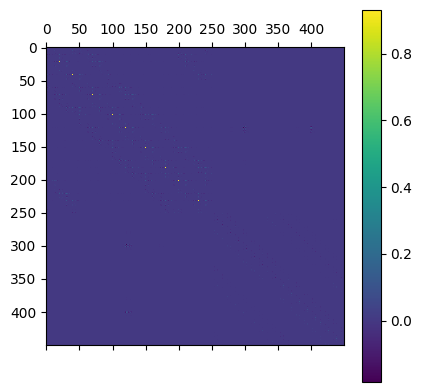

In [29]:
plt.matshow((kfock[ifr][0] -rhk[ifr][0].numpy()).real)
plt.colorbar()

In [444]:
kfock[ifr][ik][1,12],rhk[ifr][ik].numpy()[1,12]*200


(tensor(0.0570+0.j), (0.05144206335160119+0j))

In [559]:
from scipy.linalg import eigvalsh
eigactual = []
eigcut=[]
for ik in range(len(dataset.fock_kspace[0])):
    eigactual.append(eigvalsh(dataset.fock_kspace[0][ik].numpy(), dataset.overlap_kspace[0][ik].numpy()))
    eigcut.append(eigvalsh(rhk[0][ik].numpy(), rSk[0][ik].numpy()))
eigactual = np.concatenate(eigactual)
eigcut = np.concatenate(eigcut)    

(-2.0, 0.6524677627897296)

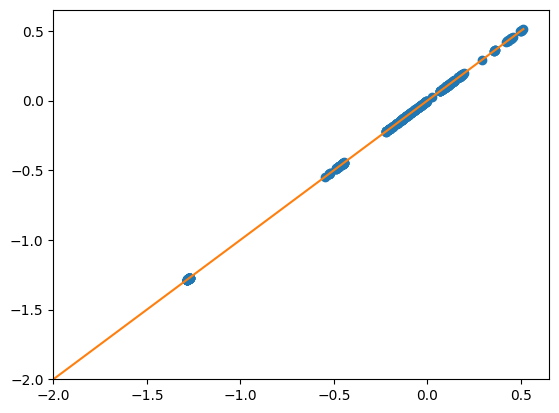

In [560]:
plt.plot(eigactual, eigcut, 'o')
plt.plot([np.min(eigactual), np.max(eigactual)],[np.min(eigactual), np.max(eigactual)])
plt.ylim(-2,)
plt.xlim(-2,)

In [36]:
blocks = matrix_to_blocks(dataset, cutoff = cutoff, all_pairs= ALL_PAIRS, sort_orbs=SORT_ORBS)#, target='overlap')
blocks_S = matrix_to_blocks(dataset, cutoff = cutoff, all_pairs= ALL_PAIRS, target='overlap', sort_orbs=SORT_ORBS)

In [37]:
rh = blocks_to_matrix(blocks, dataset, all_pairs=ALL_PAIRS, sort_orbs=SORT_ORBS)
rS = blocks_to_matrix(blocks_S, dataset, all_pairs=ALL_PAIRS, sort_orbs=SORT_ORBS)

In [39]:
kfock = dataset.fock_realspace
for ifr in range(len(kfock)):
    for ik in kfock[ifr]:
        # print(np.linalg.norm(kfock[ifr][ik] -kfock[ifr][ik].conj().T))
        print(np.linalg.norm(kfock[ifr][ik]-rh[ifr][ik].numpy()))

7.307318575549316e-14
2.2662945240885274e-16
2.2662945240885274e-16
2.270770015247583e-16
2.270770015247583e-16
6.81885129995414e-17
7.496116907552587e-18
7.496116907552588e-18
6.81885129995414e-17


# Equivariance 

In [ ]:
workdir = '.'
root = f'{workdir}/examples/data/periodic'
ORBS = 'sto-3g'
START = 0
STOP = 3
frames = read(f'{root}/graphene_supercell_variety/graphene_variety.xyz', slice(START, STOP))
for f in frames:
    f.pbc= True

kmesh = [[8,8,1], [4,4,1]]
kfock = [np.load(f"{root}/graphene_supercell_variety/fock_{i}.npy", allow_pickle = True) for i in range(START, STOP)]
kover = [np.load(f"{root}/graphene_supercell_variety/over_{i}.npy", allow_pickle = True) for i in range(START, STOP)]

dataset = PySCFPeriodicDataset(frames = frames, 
                               kmesh = kmesh, 
                               fix_p_orbital_order=True,
                               dimension = 2,
                               fock_kspace = kfock, 
                               overlap_kspace = kover, 
                               device = device, 
                               orbs = orbitals[ORBS], 
                               orbs_name = 'sto-3g')

# Graphene - UC

In [9]:
workdir = './'
START = 0 
STOP=1
ORBS = 'sto-3g'
root = f'{workdir}/examples/data/periodic/c2/cp2k/sto-3g'
data_dir = root
frames = read(f'{data_dir}/C2_174.extxyz', slice(START, STOP))
rfock = [np.load(f"{data_dir}/881/realfock_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]
rover = [np.load(f"{data_dir}/881/realoverlap_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]
kmesh = [[12,12,1]]
dataset = PySCFPeriodicDataset(frames = frames, 
                               kmesh = kmesh, 
                               dimension = 2,
                               fock_realspace = rfock, 
                               overlap_realspace = rover, 
                               device = device, 
                               orbs = orbitals[ORBS], 
                               orbs_name = 'sto-3g')

In [ ]:
cutoff = 8
SORT_ORBS = True
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = False, sort_orbs=SORT_ORBS)
target_blocks1, target_coupled_blocks1= get_targets(dataset, cutoff = cutoff, device = device, all_pairs = True, sort_orbs = SORT_ORBS)

# Graphene - deepH

In [648]:
# kfock = deepcopy(dataset.fock_kspace)

In [10]:
workdir = './'
START = 0 
STOP=1
ORBS = 'sto-3g'
root = f'{workdir}/examples/data/periodic/deepH_graphene/wrap/'
data_dir = root
frames = read(f'{data_dir}/wrapped_deepH_graphene.xyz', slice(START, STOP))
rfock = [np.load(f"{data_dir}/realfock_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]
rover = [np.load(f"{data_dir}/realoverlap_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]
kmesh = [[1,1,1]]
dataset = PySCFPeriodicDataset(frames = frames, 
                               kmesh = kmesh, 
                               dimension = 2,
                               fock_realspace = rfock, 
                               # overlap_realspace = rover, 
                               # fock_kspace = kfock,
                               device = device, 
                               orbs = orbitals[ORBS], 
                               orbs_name = 'sto-3g')

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/data/dataset.py:891: UserWarning: Overlap matrices not provided
  warnings.warn("Overlap matrices not provided")


In [11]:
ALL_PAIRS = False
SORT_ORBS = True

In [13]:
# target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = 23, device = device, all_pairs = ALL_PAIRS, sort_orbs=SORT_ORBS)

In [14]:
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = ALL_PAIRS, sort_orbs=SORT_ORBS)

In [10]:
# kblocks = kmatrix_to_blocks(dataset, cutoff = cutoff, all_pairs= ALL_PAIRS, sort_orbs=SORT_ORBS)#, target='overlap')
# kblocks_o = kmatrix_to_blocks(dataset, cutoff = cutoff, all_pairs= ALL_PAIRS, target='overlap', sort_orbs=SORT_ORBS)

In [188]:
cutoff = 23
for ALL_PAIRS in [False,True]:
    for SORT_ORBS in [True,False]:#, True]
        try:
            blocks = matrix_to_blocks(dataset, cutoff = cutoff, all_pairs = ALL_PAIRS, sort_orbs=SORT_ORBS)
            rht = blocks_to_matrix(blocks, dataset, all_pairs=ALL_PAIRS, sort_orbs=SORT_ORBS)        
            for ifr in range(len(dataset.fock_realspace)):
                for ik in dataset.fock_realspace[ifr]:
                    # print(np.linalg.norm(kfock[ifr][ik] -kfock[ifr][ik].conj().T))
                    # print(np.linalg.norm(kfock[ifr][ik]-rhk[ifr][ik].numpy()))
                    assert (np.linalg.norm(dataset.fock_realspace[ifr][ik]-rht[ifr][ik].numpy()))<1e-13, (ALL_PAIRS, SORT_ORBS)
            print(ALL_PAIRS, SORT_ORBS, 'passed')
        except:
            print(ALL_PAIRS, SORT_ORBS, 'failed - moving on')
            break

False True passed
False False passed
True True passed
True False passed


In [635]:
cutoff = 23
for ALL_PAIRS in [False,True]:
    for SORT_ORBS in [False,True,]:
        try:
            kblocks = kmatrix_to_blocks(dataset, cutoff = cutoff, all_pairs = ALL_PAIRS, sort_orbs=SORT_ORBS)
            rhk = kblocks_to_matrix(kblocks, dataset, all_pairs=ALL_PAIRS, sort_orbs=SORT_ORBS)        
            for ifr in range(len(dataset.fock_kspace)):
                for ik in range(len(dataset.fock_kspace[ifr])):
                    # print(np.linalg.norm(kfock[ifr][ik] -kfock[ifr][ik].conj().T))
                    # print(np.linalg.norm(kfock[ifr][ik]-rhk[ifr][ik].numpy()))
                    assert (np.linalg.norm(dataset.fock_kspace[ifr][ik]-rhk[ifr][ik].numpy()))<1e-13, (ALL_PAIRS, SORT_ORBS)
            print(ALL_PAIRS, SORT_ORBS, 'passed')
        except:
            print(ALL_PAIRS, SORT_ORBS, 'failed - moving on')
            continue

False False passed
False True passed
True False passed
True True passed


In [15]:
cutoff = 8
SORT_ORBS = True
ALL_PAIRS = False

# target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = False, sort_orbs=SORT_ORBS)
# target_blocks1, target_coupled_blocks1= get_targets(dataset, cutoff = cutoff, device = device, all_pairs = True, sort_orbs = SORT_ORBS)

In [16]:
kblocks = kmatrix_to_blocks(dataset, cutoff = cutoff, all_pairs= ALL_PAIRS, sort_orbs=SORT_ORBS)#, target='overlap')
# kblocks_o = kmatrix_to_blocks(dataset, cutoff = cutoff, all_pairs= ALL_PAIRS, target='overlap', sort_orbs=SORT_ORBS)

In [15]:
rhk = kblocks_to_matrix(kblocks, dataset, all_pairs=ALL_PAIRS, sort_orbs=SORT_ORBS)
# rSk = kblocks_to_matrix(kblocks_o, dataset, all_pairs=ALL_PAIRS, sort_orbs=SORT_ORBS)

In [16]:
kfock = dataset.fock_kspace
for ifr in range(len(kfock)):
    for ik in range(len(kfock[ifr])):
        # print(np.linalg.norm(kfock[ifr][ik] -kfock[ifr][ik].conj().T))
        print(np.linalg.norm(kfock[ifr][ik]-rhk[ifr][ik].numpy())/np.prod(rhk[ifr][ik].numpy().shape))

7.5042467204497645e-19


In [12]:
ALL_PAIRS = True
SORT_ORBS = False

In [14]:
max_radial  = 6
max_angular = 4
atomic_gaussian_width = 0.8
cutoff= 8
spline_basis = False


hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": splined_basis if spline_basis else {"Gto": {}},
               # "radial_basis": splined_basis,
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}
LCUT=4
hfeat = compute_features(dataset, ALL_PAIRS)

cpu pair features


/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/features/acdc.py:147: UserWarning: The selected cutoff is less than the maximum distance as repeated for kmesh (23.0) among atoms in the system!
  warnings.warn(f"The selected cutoff is less than the maximum distance as repeated for kmesh ({np.ceil(min_cutoff)}) among atoms in the system!")


cpu single center features
cpu single center features


In [20]:
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = ALL_PAIRS, sort_orbs=SORT_ORBS)
kblocks = kmatrix_to_blocks(dataset, cutoff = cutoff, all_pairs= ALL_PAIRS, sort_orbs=SORT_ORBS)

In [21]:
phase, indices, kpts_idx = precompute_phase(target_blocks, dataset, cutoff)
pred_kspace = TMap_bloch_sums(target_blocks, phase, indices, kpts_idx, return_tensormap = True)

In [24]:
for k, b in kblocks.items():
    b1 = pred_kspace.block(k)
    # print(b1.values.shape, b.values.shape)
    print(torch.norm(b1.values -b.values))

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(1.6217e-10)
tensor(7.0422e-13)
tensor(2.0176e-14)
tensor(5.2733e-15)
tensor(1.7249e-18)
tensor(4.2032e-11)
tensor(1.2828e-13)
tensor(6.1371e-10)


In [20]:
seed = 10
torch.manual_seed(seed)
np.random.seed(seed)
      
model = LinearModelPeriodic(twocfeat = hfeat, 
                            target_blocks = target_coupled_blocks,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            bias = False, #True
                            nhidden = 512, 
                            nlayers = 1,
                            # activation = 'SiLU',
                            # apply_norm = True
                           )

model = model.double()

In [21]:
pred = model()#.predict(hfeat, target_coupled_blocks)

In [23]:

# blocks = matrix_to_blocks(dataset, cutoff = cutoff, all_pairs = ALL_PAIRS, sort_orbs=SORT_ORBS)
rht = blocks_to_matrix(pred, dataset, all_pairs=ALL_PAIRS, sort_orbs=SORT_ORBS)        

paolo- pls kill me
1


AssertionError: 0.07661854154620631

In [24]:
rht = blocks_to_matrix(pred, dataset, all_pairs=ALL_PAIRS, sort_orbs=SORT_ORBS)        

paolo- pls kill me
1


AssertionError: 0.07661854154620631

In [25]:
rht = blocks_to_matrix(pred, dataset, all_pairs=ALL_PAIRS, sort_orbs=SORT_ORBS)        

paolo- pls kill me
1


AssertionError: 0.07661854154620631

In [ ]:
rht = blocks_to_matrix(pred, dataset, all_pairs=ALL_PAIRS, sort_orbs=SORT_ORBS)        

In [21]:
for ifr in range(len(dataset)):
    for T in rht[ifr]:
        mT = tuple(-t for t in T)
        print(T,torch.norm(rht[ifr][T]- rht[ifr][mT].T ))

(-1, -1, 0) tensor(1.1398e-17, grad_fn=<LinalgVectorNormBackward0>)
(1, 1, 0) tensor(1.1398e-17, grad_fn=<LinalgVectorNormBackward0>)
(-1, 0, 0) tensor(2.2271e-17, grad_fn=<LinalgVectorNormBackward0>)
(1, 0, 0) tensor(2.2271e-17, grad_fn=<LinalgVectorNormBackward0>)
(-1, 1, 0) tensor(2.6935e-18, grad_fn=<LinalgVectorNormBackward0>)
(1, -1, 0) tensor(2.6935e-18, grad_fn=<LinalgVectorNormBackward0>)
(0, -1, 0) tensor(2.1151e-17, grad_fn=<LinalgVectorNormBackward0>)
(0, 1, 0) tensor(2.1151e-17, grad_fn=<LinalgVectorNormBackward0>)
(0, 0, 0) tensor(0.0766, grad_fn=<LinalgVectorNormBackward0>)


In [20]:
print_matrix(rht[ifr][0,0,0][0:5,0:5])#- rht[ifr][mT])

  -0.1438080400    0.0163211141   -0.0003458754   -0.0012128886    0.0008770469
   0.0163211141    0.0866220588   -0.0008956318    0.0118589931   -0.0011504079
  -0.0003458754   -0.0008956318   -0.0107089306   -0.0024883392    0.0004461905
  -0.0012128886    0.0118589931    0.0052453184    0.0619122717    0.0046752007
   0.0008770469   -0.0011504079   -0.0006878737    0.0072975721   -0.0115548706


In [23]:
print_matrix(dataset.fock_realspace[ifr][0,0,0][0:5,0:5])

  -9.7232526520   -2.6651598479   -0.0002949812    0.0005615954    0.0004870117
  -2.6651598479   -1.2911516244   -0.0024372097    0.0053922133    0.0105065572
  -0.0002949812   -0.0024372097   -0.3178711761    0.0169003785   -0.0022528089
   0.0005615954    0.0053922133    0.0169003785   -0.1114970860    0.0110889848
   0.0004870117    0.0105065572   -0.0022528089    0.0110889848   -0.3003607026


In [1]:
import metatensor.torch

In [29]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat, 
                                  target_blocks = target_coupled_blocks,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-12, -2, 100),
                                                                         # alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(4.7433)


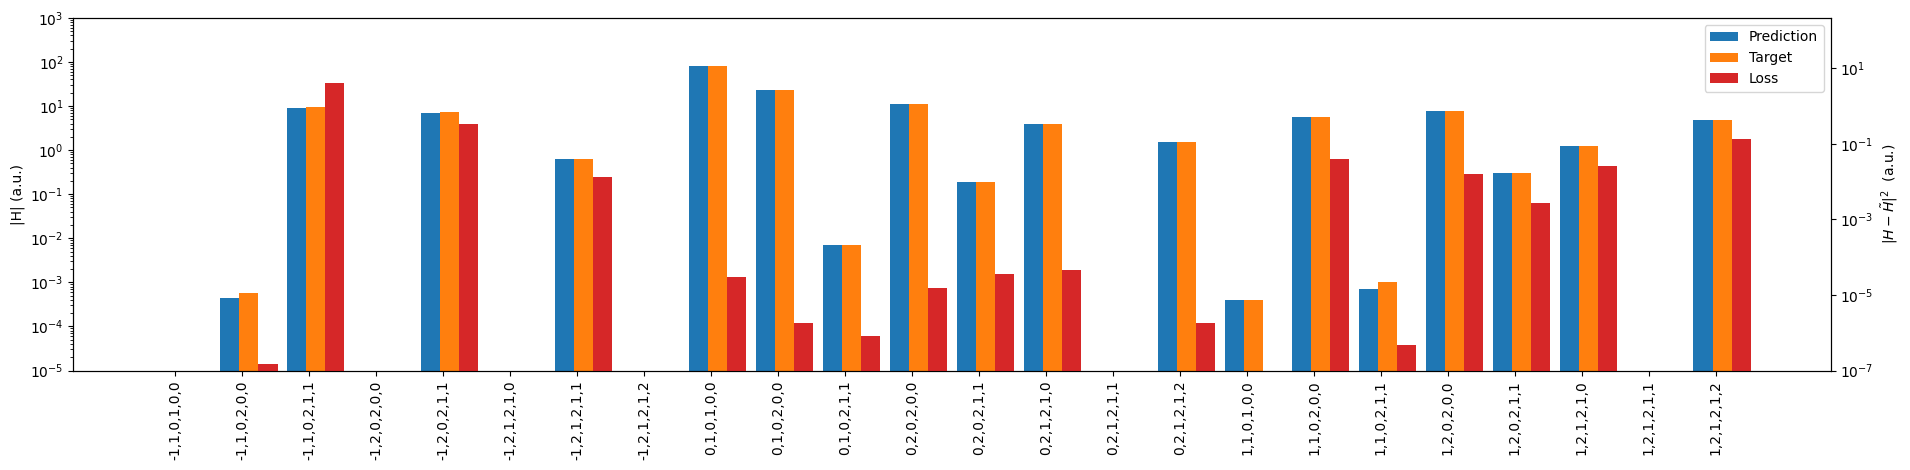

In [30]:
fig,ax,ax_loss=plot_block_errors(target_coupled_blocks, pred_ridge_bias, plot_loss = True)
ax_loss.set_ylim(1e-7,)
ax.set_ylim(1e-5,)
fig.tight_layout()

In [31]:
rht_ridge = blocks_to_matrix(pred_ridge_bias, dataset,all_pairs  =ALL_PAIRS, sort_orbs=SORT_ORBS)


In [45]:
for k,b in pred_ridge_bias.items():
    assert np.linalg.norm(np.array(b.samples.values) - np.array(target_coupled_blocks.block(k).samples.values))<=1e-13

In [32]:
for ifr in range(len(dataset)):
    for T in rht_ridge[ifr]:
        print(torch.norm(rht_ridge[ifr][T] - dataset.fock_realspace[ifr][T]) )

tensor(0.5255)
tensor(0.5255)
tensor(0.8832)
tensor(0.8832)
tensor(0.3191)
tensor(0.3191)
tensor(0.8549)
tensor(0.8549)
tensor(2.3577)


In [34]:
rhk_ridge_fourier = dataset.bloch_sum(rht_ridge)

In [37]:
for ifr in range(len(dataset)):
    for ik in range(len(rhk_ridge_fourier[ifr])):
        print(ik, torch.norm(rhk_ridge_fourier[ifr][ik] - dataset.fock_kspace[ifr][ik]) )

0 tensor(3.0631)


In [871]:
from scipy.linalg import eigvalsh
eigactual = []
eigcut=[]
for ik in range(len(dataset.fock_kspace[0])):
    eigactual.append(eigvalsh(dataset.fock_kspace[0][ik].numpy(), dataset.overlap_kspace[0][ik].numpy()))
    eigcut.append(eigvalsh(rhk[0][ik].numpy(), rSk[0][ik].numpy()))
eigactual = np.concatenate(eigactual)
eigcut = np.concatenate(eigcut)    

ValueError: wrong b dimensions (10, 10), should be (360, 360)

ValueError: x and y must have same first dimension, but have shapes (1, 360) and (0,)

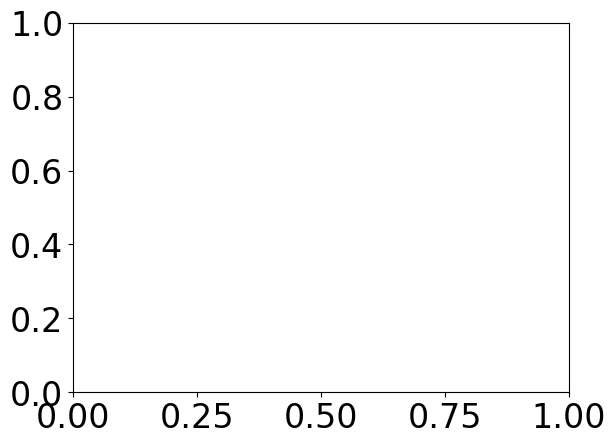

In [872]:
plt.plot(eigactual, eigcut, 'o')
plt.plot([np.min(eigactual), np.max(eigactual)],[np.min(eigactual), np.max(eigactual)])
plt.ylim(-2,)
plt.xlim(-2,)


# HEX-HEX22

In [10]:
workdir = '.'
root = f'{workdir}/examples/data/periodic'
ORBS = 'sto-3g'
START = 1
STOP = 2
# frames = read(f'{root}/graphene_supercell_variety/graphene_variety.xyz', slice(START, STOP))
frames = read(f'{root}/graphene_supercell_variety/cp2k_tight/graphene_variety_wrapped.xyz', slice(START, STOP))
for f in frames:
    f.pbc= True

# kmesh = [[8,8,1], [4,4,1]]
# kfock = [np.load(f"{root}/graphene_supercell_variety/fock_{i}.npy", allow_pickle = True) for i in range(START, STOP)]
# kover = [np.load(f"{root}/graphene_supercell_variety/over_{i}.npy", allow_pickle = True) for i in range(START, STOP)]


kmesh = [[24,24,1]]#, [12,12,1]]#, [6,6,1]]
# kfock = [np.load(f"{root}/graphene_supercell_variety/cp2k_tight/fock_{i}.npy", allow_pickle = True) for i in range(START, STOP)]
# kover = [np.load(f"{root}/graphene_supercell_variety/cp2k_tight/overlap_{i}.npy", allow_pickle = True) for i in range(START, STOP)]
rfock = [np.load(f"{root}/graphene_supercell_variety/cp2k_tight/realfock_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]
rover = [np.load(f"{root}/graphene_supercell_variety/cp2k_tight/realoverlap_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]

# kfock_o=[]
# for ifr in range(len(dataset)):
#     kifr=[]
#     for ik in range(len(dataset.fock_kspace[ifr])):
#         kifr.append(lowdin_orthogonalize(dataset.fock_kspace[ifr][ik],dataset.overlap_kspace[ifr][ik]))
#     kfock_o.append(torch.stack(kifr))
dataset = PySCFPeriodicDataset(frames = frames, 
                               kmesh = kmesh, 
                               fix_p_orbital_order=False,
                               dimension = 2,
                               # fock_kspace = kfock, 
                               fock_realspace = rfock, 
                               # overlap_kspace = kover, 
                               device = device, 
                               orbs = orbitals[ORBS], 
                               orbs_name = 'sto-3g')

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/data/dataset.py:891: UserWarning: Overlap matrices not provided
  warnings.warn("Overlap matrices not provided")


In [637]:
for ALL_PAIRS in [True, False]:
    kblocks = kmatrix_to_blocks(dataset, cutoff=cutoff,all_pairs =ALL_PAIRS, sort_orbs=SORT_ORBS )
    rec = kblocks_to_matrix(kblocks, dataset, all_pairs =ALL_PAIRS, sort_orbs=SORT_ORBS)
    print(ALL_PAIRS,torch.norm(rec[0]- dataset.fock_kspace[0]))

True tensor(6.7518e-14)
False tensor(6.7518e-14)


In [11]:
ALL_PAIRS = False
SORT_ORBS = True

In [12]:
cutoff = 8
target_blocks, target_coupled_blocks  = get_targets(dataset, cutoff = cutoff, device = device, all_pairs =ALL_PAIRS, sort_orbs=SORT_ORBS)

(<Figure size 1920x480 with 2 Axes>, <Axes: ylabel='|H| (a.u.)'>, <Axes: >)

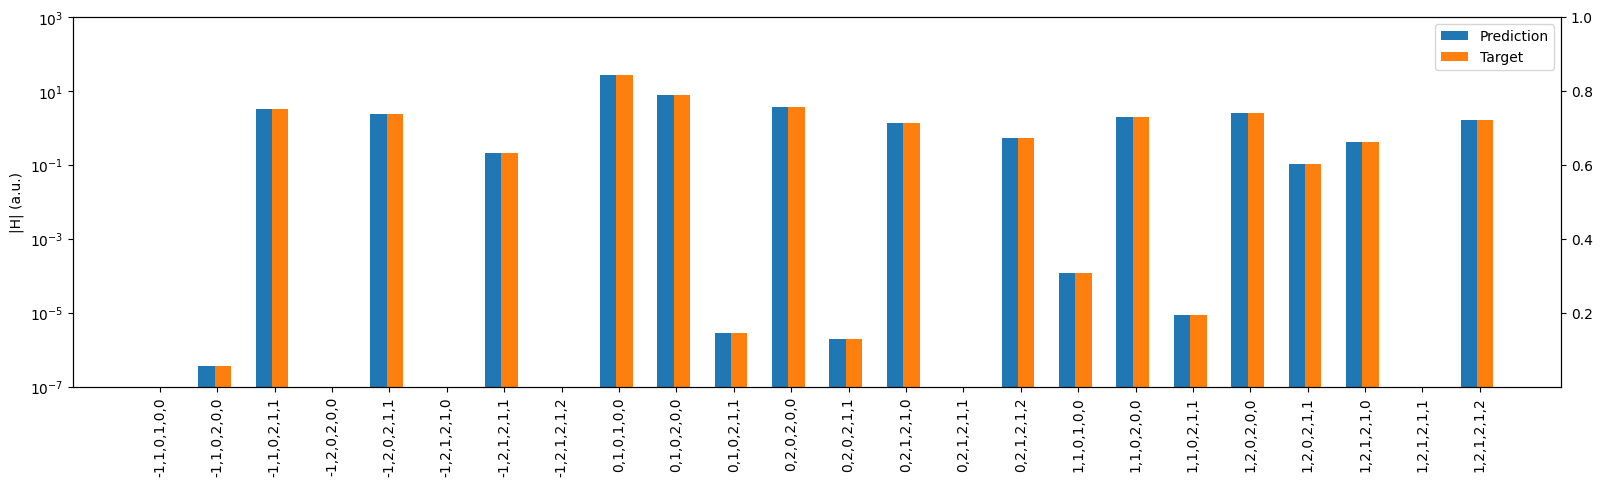

In [14]:
plot_block_errors(target_coupled_blocks, target_coupled_blocks, )

In [32]:
seed = 10
torch.manual_seed(seed)
np.random.seed(seed)

model = LinearModelPeriodic(twocfeat = hfeat, 
                            target_blocks = target_coupled_blocks,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            bias = True,
                            nhidden = 512, 
                            nlayers = 1,
                            activation = 'SiLU',
                            apply_norm = True
                           )

model = model.double()

In [34]:
from mlelec.utils.twocenter_utils import _to_uncoupled_basis

In [43]:
pred = model()
unc_pred = _to_uncoupled_basis(pred)
pred_kspace = TMap_bloch_sums(unc_pred, phase, indices, kpts_idx, return_tensormap = True)

In [45]:
from mlelec.metrics import L2_loss 
L2_loss(pred_kspace, kblocks)

tensor(959898.2832, grad_fn=<AddBackward0>)

In [44]:
metatensor.equal_metadata(pred_kspace, kblocks)

True

In [15]:
kblocks = kmatrix_to_blocks(dataset, cutoff=cutoff,all_pairs =ALL_PAIRS, sort_orbs=SORT_ORBS )

In [29]:
kblocks[1].samples

Labels(
    structure  center  neighbor  kpoint
        0        0        0        1
        0        0        0        2
        0        0        0        3
        0        0        0        4
        0        0        0        5
        0        0        0        6
        0        0        0        7
        0        0        0        8
        0        0        0        9
        0        0        0        10
        0        0        0        11
        0        0        0        12
        0        0        0        13
        0        0        0        14
        0        0        0        15
        0        0        0        16
        0        0        0        17
        0        0        0        18
        0        0        0        19
        0        0        0        20
        0        0        0        21
        0        0        0        22
        0        0        0        23
        0        0        0        24
        0        0        0        25
        0  

In [25]:
torch.norm(kblocks[0].values[:])

tensor(0.)

In [28]:
kblocks[0].samples

Labels(
    structure  center  neighbor  kpoint
        0        0        0        1
        0        0        0        2
        0        0        0        3
        0        0        0        4
        0        0        0        5
        0        0        0        6
        0        0        0        7
        0        0        0        8
        0        0        0        9
        0        0        0        10
        0        0        0        11
        0        0        0        12
        0        0        0        13
        0        0        0        14
        0        0        0        15
        0        0        0        16
        0        0        0        17
        0        0        0        18
        0        0        0        19
        0        0        0        20
        0        0        0        21
        0        0        0        22
        0        0        0        23
        0        0        0        24
        0        0        0        25
        0  

In [642]:
rr ={}
for ALL_PAIRS in [True, False]:
    target_blocks, target_coupled_blocks  = get_targets(dataset, cutoff = cutoff, device = device, all_pairs =ALL_PAIRS, sort_orbs=SORT_ORBS)
    rr[ALL_PAIRS] = blocks_to_matrix(target_coupled_blocks, dataset, all_pairs =ALL_PAIRS, sort_orbs=SORT_ORBS )

In [643]:
len(rr[True][0]) , len(rr[False][0])

(51, 51)

In [644]:
for ifr in range(len(dataset)):
    for T in rr[True][ifr]:
        print(T, torch.norm(rr[True][ifr][T] - rr[False][ifr][T]))

(-4, 1, 0) tensor(1.4677e-21)
(4, -1, 0) tensor(1.1986e-21)
(-4, 2, 0) tensor(1.1985e-21)
(4, -2, 0) tensor(2.0751e-21)
(-3, -1, 0) tensor(3.1778e-22)
(3, 1, 0) tensor(3.1778e-22)
(-3, 0, 0) tensor(0.0002)
(3, 0, 0) tensor(0.0002)
(-3, 1, 0) tensor(0.0003)
(3, -1, 0) tensor(0.0003)
(-3, 2, 0) tensor(0.0003)
(3, -2, 0) tensor(0.0003)
(-3, 3, 0) tensor(0.0002)
(3, -3, 0) tensor(0.0002)
(-2, -2, 0) tensor(2.0816e-28)
(2, 2, 0) tensor(2.0816e-28)
(-2, -1, 0) tensor(0.0003)
(2, 1, 0) tensor(0.0003)
(-2, 0, 0) tensor(0.0011)
(2, 0, 0) tensor(0.0011)
(-2, 1, 0) tensor(0.0088)
(2, -1, 0) tensor(0.0088)
(-2, 2, 0) tensor(0.0011)
(2, -2, 0) tensor(0.0011)
(-2, 3, 0) tensor(0.0003)
(2, -3, 0) tensor(0.0003)
(-2, 4, 0) tensor(1.1985e-21)
(2, -4, 0) tensor(1.1985e-21)
(-1, -3, 0) tensor(2.9947e-22)
(1, 3, 0) tensor(2.9947e-22)
(-1, -2, 0) tensor(0.0003)
(1, 2, 0) tensor(0.0003)
(-1, -1, 0) tensor(0.0088)
(1, 1, 0) tensor(0.0088)
(-1, 0, 0) tensor(0.4619)
(1, 0, 0) tensor(0.4619)
(-1, 1, 0) tensor(0

In [625]:
rHT = blocks_to_matrix(target_blocks, dataset, all_pairs =ALL_PAIRS, sort_orbs=SORT_ORBS )
rHk = dataset.bloch_sum(rHT)
for ifr in range(len(dataset)):
    print(torch.norm(rHk[ifr]-dataset.fock_kspace[ifr]))

tensor(0.0261)
tensor(0.0261)


# Targets

In [615]:
tk = {}
k_target_blocks = {}
for ALL_PAIRS in [True, False]:
    cutoff = 8
    target_blocks, target_coupled_blocks  = get_targets(dataset, cutoff = cutoff, device = device, all_pairs =ALL_PAIRS, sort_orbs=SORT_ORBS)
    phase, indices, kpts_idx = precompute_phase(target_blocks, dataset, cutoff = cutoff)
    tk[ALL_PAIRS] = TMap_bloch_sums(target_blocks, phase, indices, kpts_idx, return_tensormap = True)
    
    rec_HT = blocks_to_matrix(target_blocks, dataset, sort_orbs = SORT_ORBS, all_pairs = ALL_PAIRS)
    rec_Hk = dataset.bloch_sum(rec_HT)
    
    k_target_blocks[ALL_PAIRS] = kmatrix_to_blocks(dataset, cutoff = cutoff, all_pairs =ALL_PAIRS, sort_orbs=SORT_ORBS, matrix=rec_Hk)
    

In [617]:
for ALL_PAIRS in [True, False]:
    rec = kblocks_to_matrix(k_target_blocks[ALL_PAIRS], dataset, all_pairs =ALL_PAIRS, sort_orbs=SORT_ORBS)
    print(torch.norm(rec[0]- ))#dataset.fock_kspace[0]))

tensor(0.0379)
tensor(9.0532)


In [606]:
for (k1, b1), (k2, b2) in zip(tk[False].items(), k_target_blocks[False].items()):
    _, i1, i2 = b1.samples.intersection_and_mapping(b2.samples)
    i1=np.where(i1!=-1)
    print(torch.norm(b1.values[i1] - b2.values))

tensor(6.8314e-16)
tensor(9.4553e-05)
tensor(1.8028)
tensor(9.4553e-05)
tensor(4.9871e-15)
tensor(6.1788)
tensor(1.8028)
tensor(6.1788)
tensor(1.4179)
tensor(0.0001)
tensor(0.7809)
tensor(0.0015)
tensor(0.7809)
tensor(4.5884)
tensor(0.6530)
tensor(0.0015)
tensor(0.6530)
tensor(7.4785)


In [603]:
for (k1, b1), (k2, b2) in zip(tk[True].items(), tk[False].items()):
    _, i1, i2 = b1.samples.intersection_and_mapping(b2.samples)
    i1=np.where(i1!=-1)
    print(torch.norm(b1.values[i1] - b2.values))

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)


In [604]:
for (k1, b1), (k2, b2) in zip(k_target_blocks[True].items(), k_target_blocks[False].items()):
    _, i1, i2 = b1.samples.intersection_and_mapping(b2.samples)
    i1=np.where(i1!=-1)
    print(torch.norm(b1.values[i1] - b2.values))

tensor(1.5922e-19)
tensor(9.4553e-05)
tensor(1.8028)
tensor(9.4553e-05)
tensor(6.2288e-16)
tensor(6.1788)
tensor(1.8028)
tensor(6.1788)
tensor(1.4179)
tensor(0.0001)
tensor(0.7809)
tensor(0.0015)
tensor(0.7809)
tensor(4.5884)
tensor(0.6530)
tensor(0.0015)
tensor(0.6530)
tensor(7.4785)


In [539]:
rec_HT = blocks_to_matrix(target_blocks, dataset, sort_orbs = SORT_ORBS, all_pairs = ALL_PAIRS)
rec_Hk = dataset.bloch_sum(rec_HT)

In [541]:
phase, indices, kpts_idx = precompute_phase(target_blocks, dataset, cutoff = cutoff)
targ_kspace = TMap_bloch_sums(target_blocks, phase, indices, kpts_idx, return_tensormap = True)

In [536]:
phase_true = deepcopy(phase)
idx_true = deepcopy(indices)

In [550]:
for k in indices:
    for I in indices[k]:
        print(len(idx_true[k][I]) / len(indices[k][I]))

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [551]:
workdir = '.'
root = f'{workdir}/examples/data/periodic'
ORBS = 'sto-3g'
START = 1
STOP = 3
frames = read(f'{root}/graphene_supercell_variety/graphene_variety.xyz', slice(START, STOP))
# frames = read(f'{root}/graphene_supercell_variety/cp2k_tight/graphene_variety_wrapped.xyz', slice(START, STOP))
for f in frames:
    f.pbc= True

dataset_fake = PySCFPeriodicDataset(frames = frames, 
                               kmesh = kmesh, 
                               # fix_p_orbital_order=True,
                               dimension = 2,
                               fock_kspace = rec_Hk, 
                               device = device, 
                               orbs = orbitals[ORBS], 
                               orbs_name = 'sto-3g')

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/data/dataset.py:887: UserWarning: Overlap matrices not provided
  warnings.warn("Overlap matrices not provided")


In [552]:
k_target_blocks = kmatrix_to_blocks(dataset_fake, cutoff = cutoff, all_pairs =ALL_PAIRS, sort_orbs=SORT_ORBS)

In [553]:
metatensor.allclose(k_target_blocks, targ_kspace)

False

In [576]:
rec1 = kblocks_to_matrix(k_target_blocks, dataset_fake, all_pairs=ALL_PAIRS, sort_orbs=SORT_ORBS)
rec2 = kblocks_to_matrix(targ_kspace, dataset_fake, all_pairs=ALL_PAIRS, sort_orbs=SORT_ORBS)

In [577]:
torch.norm(rec_Hk[0] - rec1[0]), torch.norm(rec_Hk[0] - rec2[0])

(tensor(2.4013e-14), tensor(9.0531))

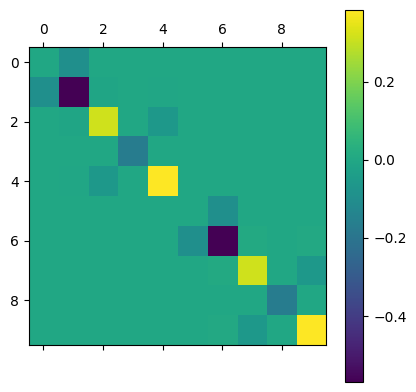

In [578]:
plt.matshow((rec_Hk[0][1] - rec2[0][1]).real)
plt.colorbar()

In [520]:
norms = np.linalg.norm(k_target_blocks[17].values.numpy(), axis=(1,2)) #-
norms_t = np.linalg.norm(targ_kspace[17].values.numpy(), axis=(1,2)) #-
# targ_kspace[17].values.numpy(), axis = (1,2))[:,0]

(0.0, 200.0)

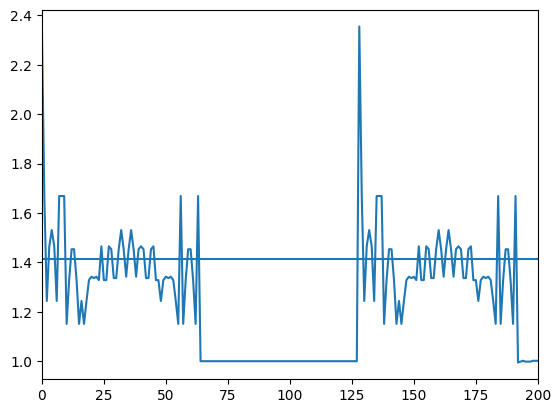

In [526]:
plt.plot(norms/norms_t)
# plt.plot(norms_t)
# plt.plot(norms_t*np.sqrt(2))
# plt.ylim(0,0.01)
plt.axhline(np.sqrt(2))
plt.xlim(0,200)

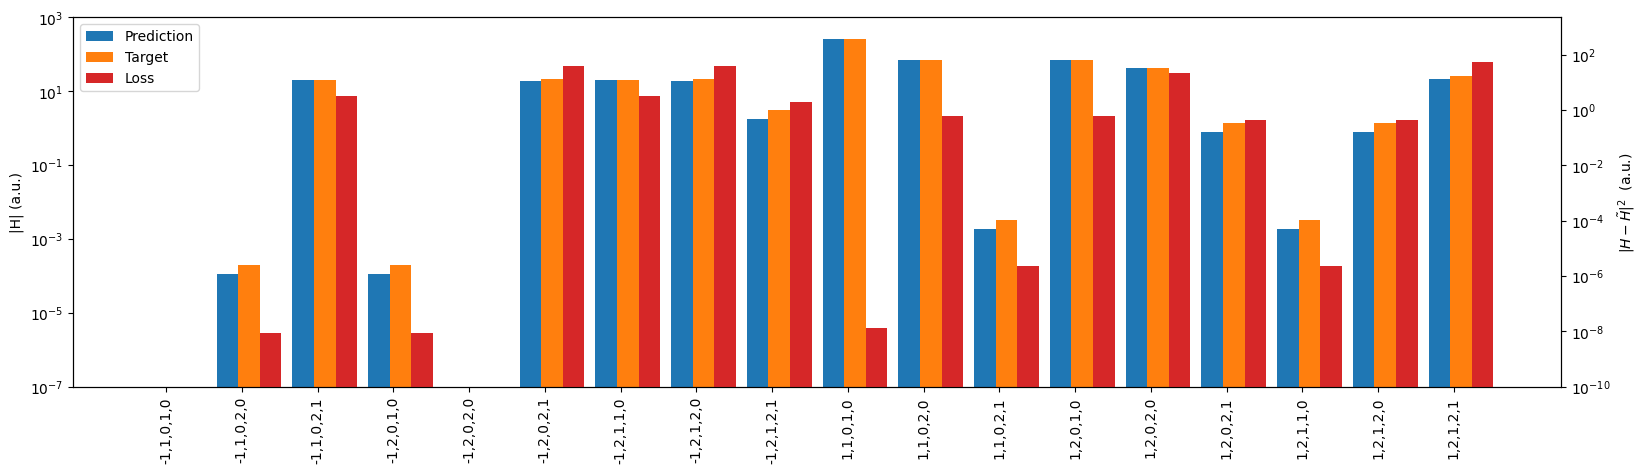

In [511]:
fig,ax,ax_loss = plot_block_errors(k_target_blocks, targ_kspace, plot_loss = True)

In [276]:
rht = blocks_to_matrix(target_coupled_blocks , dataset,all_pairs =ALL_PAIRS, sort_orbs=SORT_ORBS)

In [277]:
rht[0][2,0,0][0:5,5:10]

tensor([[-5.0169e-08,  2.1299e-06, -2.7595e-07,  5.5779e-16, -3.6945e-06],
        [ 2.1299e-06, -3.6888e-05,  2.0984e-05, -1.2474e-15,  8.7090e-05],
        [ 2.7595e-07, -2.0984e-05, -1.4206e-06, -7.1276e-16,  4.2764e-05],
        [-3.5554e-16,  9.4027e-16, -3.8401e-16,  1.0006e-03,  2.9344e-16],
        [ 3.6945e-06, -8.7090e-05,  4.2764e-05,  6.7641e-16,  1.8504e-04]])

In [292]:
k_target_blocks = kmatrix_to_blocks(dataset, cutoff = cutoff, all_pairs =ALL_PAIRS, sort_orbs=SORT_ORBS)

In [37]:
rhk =kblocks_to_matrix(k_target_blocks, dataset, all_pairs =ALL_PAIRS, sort_orbs=SORT_ORBS)
for ifr in range(len(dataset)):
    print(torch.norm(rhk[ifr]- dataset.fock_kspace[ifr]))
    # for ik in range(len(dataset.fock_kspace[ifr])):
    #     print(ifr, ik,torch.norm(rhk[ifr][ik] - dataset.fock_kspace[ifr][ik]))

tensor(6.6833e-14)
tensor(1.0077e-12)


# Features

In [279]:
from rascaline import SphericalExpansion
from rascaline import SphericalExpansionByPair as PairExpansion

In [30]:
import rascaline
max_radial  = 8
max_angular = 6
atomic_gaussian_width = 0.3
spline_basis = False
##---splined basis 
if spline_basis :
    spliner = rascaline.utils.SoapSpliner(
        cutoff=cutoff,
        max_radial=max_radial,
        max_angular=max_angular,
        basis=rascaline.utils.SphericalBesselBasis(
            cutoff=cutoff, max_radial=max_radial, max_angular=max_angular
        ),
        density=rascaline.utils.GaussianDensity(atomic_gaussian_width=atomic_gaussian_width),
        accuracy=1e-5,
    )
    splined_basis = spliner.compute()
##-------
hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": splined_basis if spline_basis else {"Gto": {}},
               # "radial_basis": splined_basis,
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

hypers_atom = {'cutoff': 4,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': 0.3,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

return_rho0ij = False
both_centers = False
LCUT = 3

def compute_features(dataset, all_pairs=ALL_PAIRS):

    rhoij = pair_features(dataset.structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = all_pairs, both_centers = both_centers, mic = False,
                          kmesh = dataset.kmesh, device = device, lcut = LCUT, return_rho0ij = return_rho0ij)  
    feature_names = rhoij.property_names
    if both_centers and not return_rho0ij:
        NU = 3
    else:
        NU = 2
        
    if return_rho0ij:
        feature_names = None
        NU=1
    rhonui = single_center_features(dataset.structures, hypers_atom, order_nu = NU, lcut = LCUT, device = device,
                                    # features_names=None)
                                    feature_names = feature_names)

    if return_rho0ij:
        return rhoij, rhonui
    hfeat = twocenter_features_periodic_NH(single_center = rhonui, pair = rhoij, all_pairs = all_pairs)

    return hfeat

In [31]:
# %%timeit
hfeat = compute_features(dataset, all_pairs= ALL_PAIRS)

cpu pair features
cpu single center features
cpu single center features


# Train

## Ridge regression

In [283]:
from mlelec.models.linear import LinearModelPeriodic
device='cpu'

In [284]:
def train_ridge(model, target_blocks, set_bias=False, alphas = None, kernel_ridge = False, alpha = None):
    block_losses = {}
    loss = 0
    pred, ridges = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias, kernel_ridge = kernel_ridge, alphas = alphas, alpha = alpha)

    for (key, block) in pred.items():
        block_loss=torch.norm(block.values - target_blocks[key].values)**2
        loss += block_loss
        
        block_losses[tuple(key.values)] = block_loss

    # print(np.sum(list(block_losses.values())))
    return loss, pred, ridges, block_losses#, kernels 

In [285]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat, 
                                  target_blocks = target_coupled_blocks,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         # alphas = np.logspace(-10, -2, 100),
                                                                         alphas = np.logspace(-10, 1, 100),
                                                                         # alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(1.3363e-05)


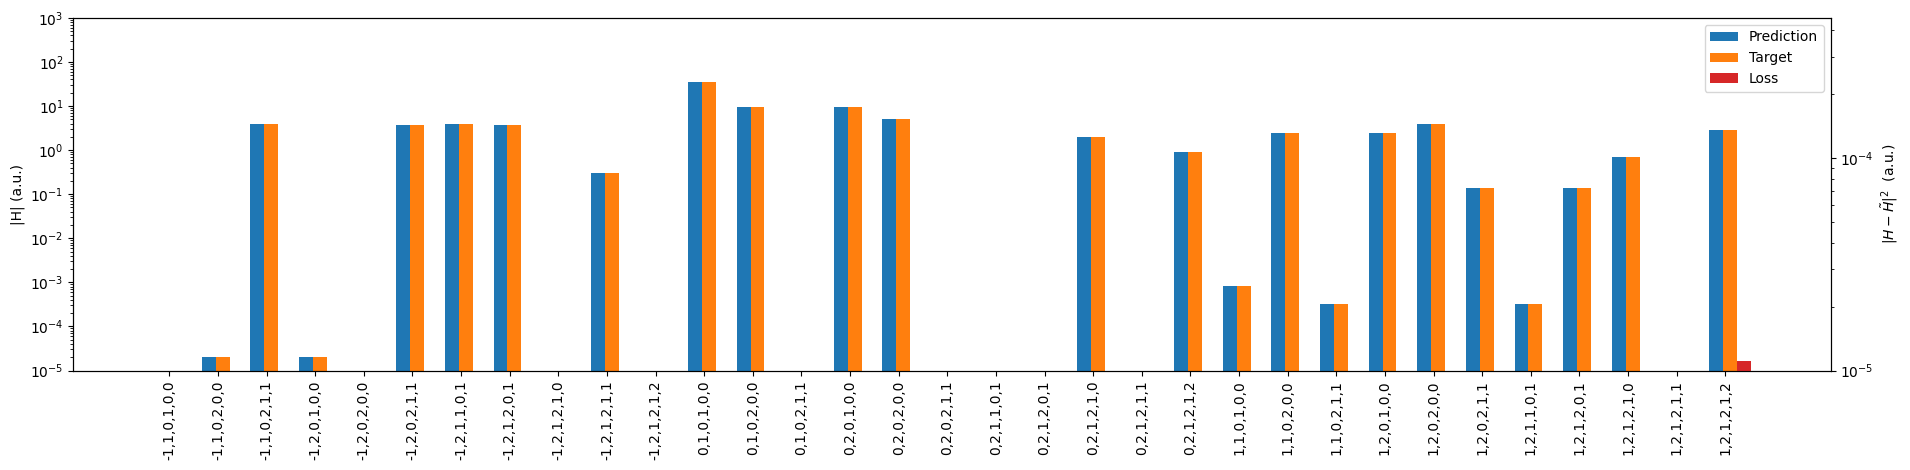

In [286]:
from mlelec.utils.plot_utils import plot_block_errors
fig,ax,ax_loss=plot_block_errors(target_coupled_blocks, pred_ridge_bias, plot_loss = True)
ax_loss.set_ylim(1e-5,)
ax.set_ylim(1e-5,)
fig.tight_layout()

In [62]:
rht_ridge = blocks_to_matrix(pred_ridge_bias , dataset,all_pairs =ALL_PAIRS, sort_orbs=SORT_ORBS)

In [121]:
rht_ridge[0][0,1,0][:5,:5] - rht_ridge[1][0,0,0][0:5,25:30]

tensor([[ 2.4666e-05,  3.5481e-01, -5.1865e-01,  0.0000e+00,  3.9378e-01],
        [ 3.5481e-01,  3.3555e-01, -2.5521e-01,  0.0000e+00,  4.1917e-01],
        [ 5.1866e-01,  3.0606e-01, -8.9197e-02,  0.0000e+00,  2.5185e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  8.8336e-02,  0.0000e+00],
        [-3.9378e-01, -4.4853e-01,  3.3887e-01,  0.0000e+00,  2.5185e-01]])

Compute the feature covariance matrix and diagonalize it. Project the weights onto the covariance eigenstates at each training iteration (TODO)

## Torch

In [287]:
from mlelec.metrics import L2_loss, L2_kspace_loss

In [288]:
from mlelec.models.linear import LinearModelPeriodic

In [289]:
from mlelec.utils.pbc_utils import blocks_to_matrix
from mlelec.utils.symmetry import ClebschGordanReal
CG = ClebschGordanReal(lmax = 3, device = device)

In [317]:
seed = 10
torch.manual_seed(seed)
np.random.seed(seed)

model = LinearModelPeriodic(twocfeat = hfeat, 
                            target_blocks = target_coupled_blocks,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            bias = True,
                            nhidden = 512, 
                            nlayers = 1,
                            activation = 'SiLU',
                            apply_norm = True
                           )

model = model.double()
# for p, (_, b) in zip(model.parameters(), target_coupled_blocks.items()):
#     p.data = torch.ones_like(p.data)

losses = {}
para = {}
grad = {}
learning_rates = {}
last_layer_kernel = {}
nepoch = 1000

# optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.6, patience=50, verbose=True)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[200, 400, 600, 800], gamma=1e-1)
optimizers = []
schedulers = []
for i, key in enumerate(model.model):
    # optimizers.append(torch.optim.Adam(model.model[key].parameters(), lr = 1e-1)) #, betas = (0.8, 0.9)))
    optimizers.append(torch.optim.AdamW(model.model[key].parameters(), lr = 1e-3, betas = (0.8, 0.9)))
    schedulers.append(torch.optim.lr_scheduler.ReduceLROnPlateau(optimizers[-1], factor = 0.8, patience = 30, verbose=True))

In [318]:
from mlelec.utils.twocenter_utils import _to_uncoupled_basis, map_targetkeys_to_featkeys
from mlelec.utils.pbc_utils import precompute_phase, TMap_bloch_sums

phase, indices, kpts_idx = precompute_phase(target_blocks, dataset, cutoff = cutoff)

loss_real = []
loss_k = []

new_sched = True
for epoch in range(nepoch):

    model.train(True)

    for ik, key in enumerate(model.model):
        optimizers[ik].zero_grad()
    
    pred = model()
    unc_pred = _to_uncoupled_basis(pred, cg = CG)
    pred_kspace = TMap_bloch_sums(unc_pred, phase, indices, kpts_idx, return_tensormap=True)
    
    n_predictions = sum([np.prod(b.values.shape) for _, b in pred.items()])

    if epoch < 100:

        # Compute the loss for each block
        all_losses, epoch_loss = L2_loss(pred, target_coupled_blocks, loss_per_block = True)

        # Total loss
        epoch_loss = epoch_loss.item()
        
        # Append the values of the loss to a list
        loss_k.append(L2_loss(pred_kspace, k_target_blocks, norm = 1).item())
        loss_real.append(epoch_loss)

        # Loop through submodels and backpropagate
        for ik, (loss, key) in enumerate(zip(all_losses, model.model)):
            loss.backward(retain_graph = False)
            torch.nn.utils.clip_grad_norm_(model.model[key].parameters(), 1)
            optimizers[ik].step()
            schedulers[ik].step(loss)
            
            if key not in losses:
                losses[key] = [loss.item()]
                learning_rates[key] = [schedulers[ik].state_dict()['_last_lr'][0]]
            else:
                losses[key].append(loss.item())
                learning_rates[key].append(schedulers[ik].state_dict()['_last_lr'][0])
                
    else:

        # Compute the loss
        loss = L2_loss(pred_kspace, k_target_blocks, norm = 2)

        # Total loss 
        epoch_loss = loss.item()
        
        # Append the values of the loss to a list
        all_losses, epoch_loss_real = L2_loss(pred, target_coupled_blocks, loss_per_block=True)
        loss_real.append(epoch_loss_real.item())
        loss_k.append(epoch_loss)

               
        loss.backward(retain_graph = True)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

        for ik, (loss_, key) in enumerate(zip(all_losses, model.model)):
            optimizers[ik].step()
            schedulers[ik].step(epoch_loss/len(model.model))
            if key not in losses:
                losses[key] = [loss_.item()]
                learning_rates[key] = [schedulers[ik].state_dict()['_last_lr'][0]]
            else:
                losses[key].append(loss_.item())
                learning_rates[key].append(schedulers[ik].state_dict()['_last_lr'][0])
        
    if epoch % 10 == 0:
        # print(f"Epoch {epoch:>7d}, train loss on all blocks {epoch_loss:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")
        print(f"Epoch {epoch:>7d}, train loss real {loss_real[-1]:>15.10f}, train loss k {loss_k[-1]:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")

Epoch       0, train loss real 1520.3510093962, train loss k 75444.4610950554, train loss per prediction 1.71392e-03
Epoch      10, train loss real  563.8272026572, train loss k 28815.6226332443, train loss per prediction 1.04374e-03
Epoch      20, train loss real   48.8332076176, train loss k 2493.9629631275, train loss per prediction 3.07168e-04
Epoch      30, train loss real    0.7638140615, train loss k   35.4507557702, train loss per prediction 3.84160e-05
Epoch      40, train loss real    0.7997072954, train loss k   37.6564149104, train loss per prediction 3.93083e-05
Epoch      50, train loss real    0.3371864903, train loss k   14.7304781176, train loss per prediction 2.55243e-05
Epoch      60, train loss real    0.1257941498, train loss k    4.1005289034, train loss per prediction 1.55901e-05
Epoch      70, train loss real    0.4112101475, train loss k   18.1246848154, train loss per prediction 2.81871e-05
Epoch      80, train loss real    0.0897991901, train loss k    3.2643

KeyboardInterrupt: 

# WHY ARE THESE SAMPLES PRESENT IN BTYPE=-1 ???? features not correct then?

In [294]:
_,id1, id2 = pred_kspace[0].samples.intersection_and_mapping(k_target_blocks[0].samples)

In [302]:
kpts = torch.from_numpy(dataset.kpts_rel[0])
kpts[torch.where(kpts.norm(dim = -1) > 1e-30)[0].tolist()]

tensor([[ 1.7534e-18,  1.2500e-01,  0.0000e+00],
        [ 3.5067e-18,  2.5000e-01,  0.0000e+00],
        [-1.9814e-17,  3.7500e-01,  0.0000e+00],
        [ 7.0135e-18,  5.0000e-01,  0.0000e+00],
        [-1.4989e-18,  6.2500e-01,  0.0000e+00],
        [-3.9627e-17,  7.5000e-01,  0.0000e+00],
        [-1.8523e-17,  8.7500e-01,  0.0000e+00],
        [ 1.2500e-01,  1.2019e-17,  0.0000e+00],
        [ 1.2500e-01,  1.2500e-01,  0.0000e+00],
        [ 1.2500e-01,  2.5000e-01,  0.0000e+00],
        [ 1.2500e-01,  3.7500e-01,  0.0000e+00],
        [ 1.2500e-01,  5.0000e-01,  0.0000e+00],
        [ 1.2500e-01,  6.2500e-01,  0.0000e+00],
        [ 1.2500e-01,  7.5000e-01,  0.0000e+00],
        [ 1.2500e-01,  8.7500e-01,  0.0000e+00],
        [ 2.5000e-01,  2.4038e-17,  0.0000e+00],
        [ 2.5000e-01,  1.2500e-01,  0.0000e+00],
        [ 2.5000e-01,  2.5000e-01,  0.0000e+00],
        [ 2.5000e-01,  3.7500e-01,  0.0000e+00],
        [ 2.5000e-01,  5.0000e-01,  0.0000e+00],
        [ 2.5000e-01

In [295]:
np.where(id1==-1)#id2

(array([  0, 128, 192, 320, 432, 528, 608, 672, 720, 752]),)

In [296]:
pred_kspace[0].samples.values[np.where(id1==-1)]

LabelsValues([[0, 0, 0, 0],
              [0, 1, 1, 0],
              [1, 0, 0, 0],
              [1, 1, 1, 0],
              [1, 2, 2, 0],
              [1, 3, 3, 0],
              [1, 4, 4, 0],
              [1, 5, 5, 0],
              [1, 6, 6, 0],
              [1, 7, 7, 0]], dtype=int32)

In [297]:
pred_kspace[0].values[np.where(id1==-1)]

tensor([[[[-0.8388+0.j]]],


        [[[-0.8388+0.j]]],


        [[[-0.1359+0.j]]],


        [[[-0.1359+0.j]]],


        [[[-0.1359+0.j]]],


        [[[-0.1359+0.j]]],


        [[[-0.1359+0.j]]],


        [[[-0.1359+0.j]]],


        [[[-0.1359+0.j]]],


        [[[-0.1359+0.j]]]], grad_fn=<IndexBackward0>)

In [364]:
pred_kspace

TensorMap with 18 blocks
keys: block_type  species_i  n_i  l_i  species_j  n_j  l_j
          -1          6       1    0       6       1    0
          -1          6       1    0       6       2    0
                              ...
          1           6       2    1       6       2    0
          1           6       2    1       6       2    1

In [316]:
k_target_blocks[0].samples.names

['structure', 'center', 'neighbor', 'kpoint']

In [315]:
k_target_blocks[0].samples.values

LabelsValues([[ 0,  0,  0,  1],
              [ 0,  0,  0,  2],
              [ 0,  0,  0,  3],
              ...,
              [ 1,  7,  7, 13],
              [ 1,  7,  7, 14],
              [ 1,  7,  7, 15]], dtype=int32)

In [282]:
pred_kspace[0].samples.values

LabelsValues([[ 0,  0,  0,  0],
              [ 0,  0,  0,  1],
              [ 0,  0,  0,  2],
              ...,
              [ 1,  7,  7, 13],
              [ 1,  7,  7, 14],
              [ 1,  7,  7, 15]], dtype=int32)

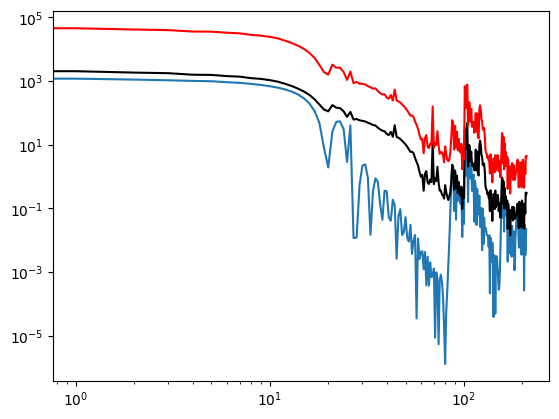

In [ ]:
for k in losses:
    if k == '(0, 6, 1, 0, 6, 1, 0, 0)':
        plt.loglog(losses[k], label = k)
# plt.ylim(1e-10)
plt.loglog(loss_real, 'k')
plt.loglog(loss_k, 'r')

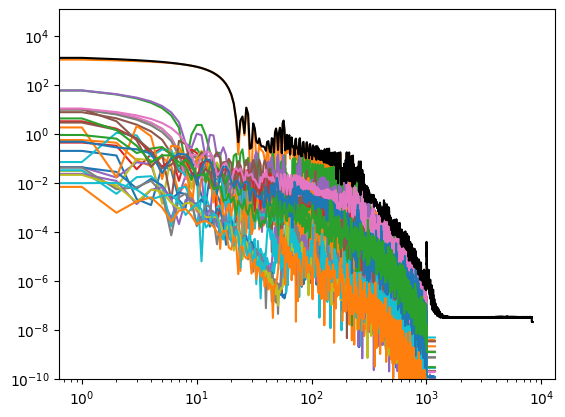

In [32]:
for k in losses:
    plt.loglog(losses[k], label = k)
plt.ylim(1e-10)
plt.loglog(loss_real, 'k')

# Bands

In [55]:
def reconstruct(pred, dataset, cutoff):
    from mlelec.utils.pbc_utils import inverse_bloch_sum
    reconstructed_H_ = blocks_to_matrix(pred, dataset)
    reconstructed_H = []
    reconstructed_S = []
    S = [inverse_bloch_sum(dataset, dataset.overlap_kspace[ifr], ifr, cutoff) for ifr in range(len(dataset.structures))]
    for ifr in range(len(reconstructed_H_)):
        reconstructed_H.append({})
        reconstructed_S.append({})
        for T in reconstructed_H_[ifr]:
            if T in S[ifr]:
                reconstructed_S[ifr][T] = S[ifr][T]
                reconstructed_H[ifr][T] = reconstructed_H_[ifr][T].cpu().detach().numpy()
            elif tuple(-np.array(T)) in S[ifr]:
                T = tuple(-np.array(T))
                reconstructed_S[ifr][T] = S[ifr][T]
                reconstructed_H[ifr][T] = reconstructed_H_[ifr][T].cpu().detach().numpy()
            else:
                print(T)
                raise ValueError()
    return reconstructed_H, reconstructed_S

In [56]:
rH_k, rS_k = reconstruct(pred, dataset, cutoff = cutoff)

_, true_target_coupled_blocks = get_targets(dataset, cutoff = 8.35, device = device)
rH_true, rS_true = reconstruct(true_target_coupled_blocks, dataset, cutoff = 8.35)

-0.007484087355638383
-0.007498410787027821


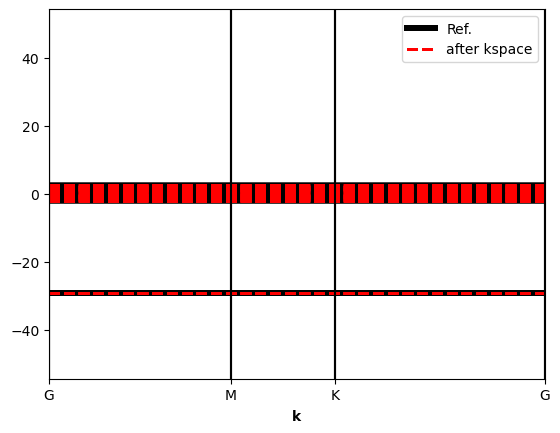

In [57]:
fig, ax = plt.subplots()

special_points = {'G': [0.0, 0.0, 0.0], 'K': [0.3333333333333333, 0.3333333333333333, 0.0], 'M': [0.5, 0.0, 0.0]}

from mlelec.utils.plot_utils import plot_bands_frame_
import matplotlib

ifr = 2
frame = dataset.structures[ifr]
pyscf_cell = dataset.cells[ifr]
kmesh = dataset.kmesh[ifr]
kpath = frame.cell.bandpath('GMKG', 500, special_points = special_points, pbc = [True, True, False])
realfock = np.asarray(list(rH_true[ifr].values())) #np.asarray(list(dataset.fock_realspace[0].values()))
realover = np.asarray(list(rS_true[ifr].values())) #np.asarray(list(dataset.overlap_realspace[0].values()))
R_vec_rel = [list(T) for T in rH_true[ifr]]

handles = []
labels = []

ax, b, handle = plot_bands_frame_(frame, realfock, realover, pyscf_cell, kmesh, special_symm = 'hexagonal', 
                                  factor = 1,
                                  kpath = kpath, ax = ax, color = 'k', R_vec_rel_in = R_vec_rel, lw = 3)
handles.append(tuple(handle))
labels.append('Ref.')

for H, S, c, ls, factor, label in zip([rH_k], [rS_k], ['red'], ['--'], [1], ['after kspace']): #np.sqrt(np.prod(kmesh)/len(H[0]))]):
    # if label == 'only real space':
        # continue
    realfock_cutoff = np.asarray(list(H[ifr].values()))
    realover_cutoff = np.asarray(list(S[ifr].values()))
    R_vec_rel = [list(T) for T in H[ifr]]
    ax, b, handle = plot_bands_frame_(frame, realfock_cutoff, realover_cutoff, pyscf_cell, kmesh, 
                                      factor = factor,
                                      lw = 2,
                                      R_vec_rel_in = R_vec_rel, special_symm = 'hexagonal', kpath = kpath, ax = ax, color = c, ls = ls)
    handles.append(tuple(handle))
    labels.append(label)

ax.legend(handles, labels)
# ax.set_ylim(-35, 43)
# nmax = 50
# for ifr in range(0, nmax):
#     frame = dataset.structures[ifr]
#     pyscf_cell = dataset.cells[ifr]
#     kmesh = dataset.kmesh[ifr]
#     kpath = frame.cell.bandpath('GMKG', 500, special_points = special_points, pbc = [True, True, False])
#     realfock = np.asarray(list(dataset.fock_realspace[ifr].values()))
#     realover = np.asarray(list(dataset.overlap_realspace[ifr].values()))
#     realfock_cutoff = np.asarray(list(reconstructed_H[ifr].values()))
#     realover_cutoff = np.asarray(list(reconstructed_S[ifr].values()))
#     fig, ax = plt.subplots()
#     ax, b = plot_bands_frame_(frame, realfock, realover, pyscf_cell, kmesh = [8,8,1], special_symm = 'hexagonal' , 
#                               kpath = kpath, ax=ax,color = cmap((ifr+1)/nmax))
#     ax, b = plot_bands_frame_(frame, realfock_cutoff, realover_cutoff, pyscf_cell, kmesh = [8,8,1], special_symm = 'hexagonal' , 
#                               kpath = kpath, ax = ax, color = 'k', ls = ':')



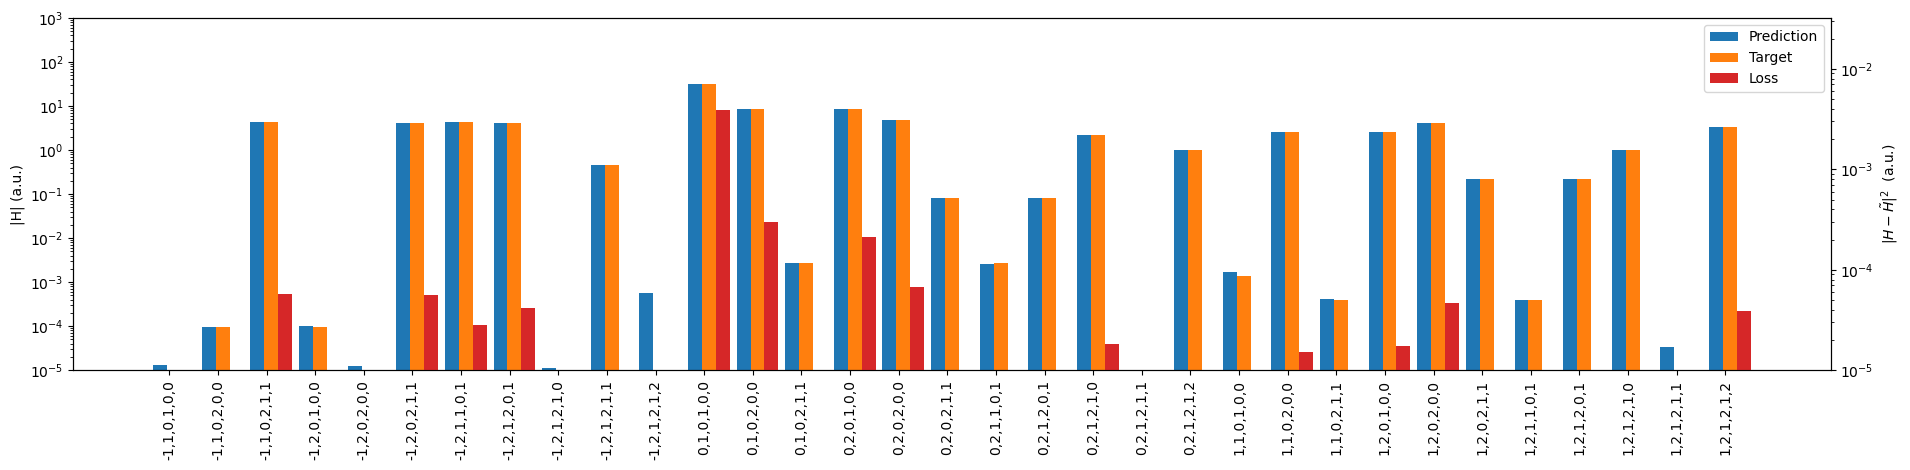